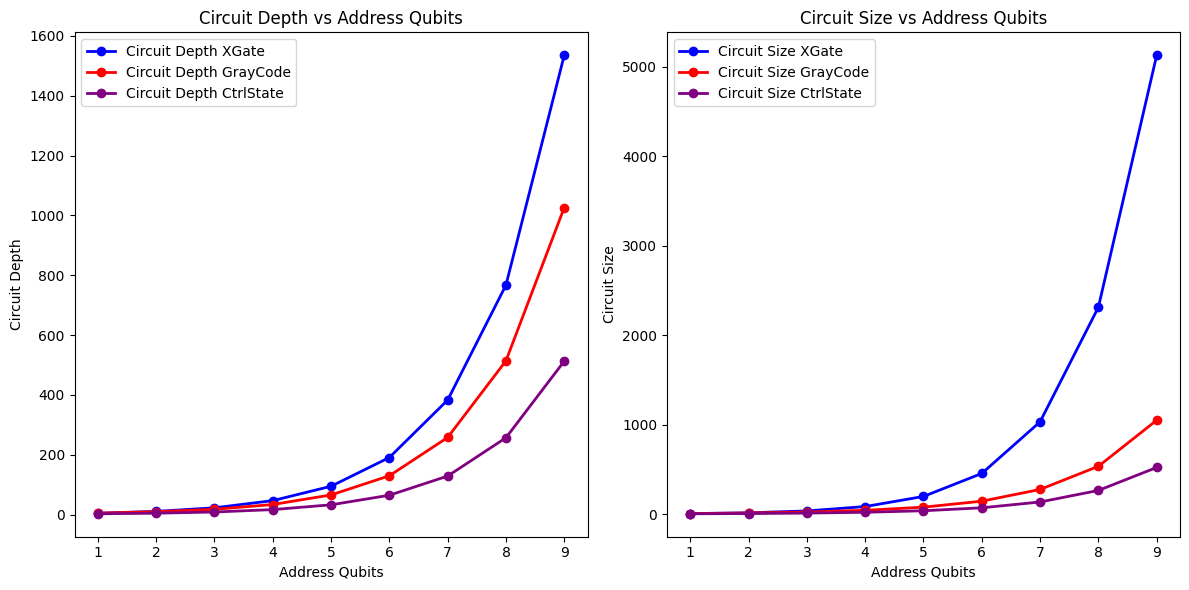

In [23]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import HGate, CXGate, RYGate, XGate
from numpy import arcsin, sqrt, pi
import math
from matplotlib import pyplot as plt
# Funzione per calcolare il valore di θ
def calculate_theta(value, max_value):
    X_N = value / sqrt(max_value)
    return 2 * arcsin(X_N)


# Funzione per generare il codice Gray
def gray_code(n):
    """Generate n-bit Gray code iteratively."""
    if n == 0:
        return ['0']
    if n == 1:
        return ['0', '1']
    
    gray_codes = ['0', '1']
    for i in range(2, n + 1):
        # Create the next sequence by reflecting the current sequence
        reflected = ['1' + code for code in reversed(gray_codes)]
        gray_codes = ['0' + code for code in gray_codes] + reflected
    
    return gray_codes

# Funzione per calcolare la profondità e la dimensione del circuito per diverse dimensioni del dataset
def calculate_circuit_metrics_XGate(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        binary_index = bin(i)[2:].zfill(n)
    
        for j, bit in enumerate(binary_index):
            if bit == '0':
                circuit.append(XGate(), [qaddr[j]])
    
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
    
        for j, bit in enumerate(binary_index):
            if bit == '0':
                circuit.append(XGate(), [qaddr[j]])
    
        circuit.barrier()


    return circuit.depth(), circuit.size()

def calculate_circuit_metrics_GrayCode(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    previous_bit = [1] * n
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    gray_codes = gray_code(n)
    binary_index = list(enumerate(gray_codes[0]))
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        for j, bit in binary_index:
            if bit == '0' and previous_bit[j] == 1:
                circuit.append(XGate(), [qaddr[j]])
            previous_bit[j] = int(bit)
        
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
        
        if i < N - 1:
            binary_index = list(enumerate(gray_codes[i + 1]))
            for j, next_bit in binary_index:
                if next_bit == '1' and previous_bit[j] == 0:
                    circuit.append(XGate(), [qaddr[j]])
        else:
            for j, bit in binary_index:
                if bit == '0':
                    circuit.append(XGate(), [qaddr[j]])
        
        circuit.barrier()

    return circuit.depth(), circuit.size()

def calculate_circuit_metrics(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    i=0
    for el in memory_values:
        theta=calculate_theta(el, max_value)
        binary_index = bin(i)[2:].zfill(n)
        CRYGate = RYGate(theta).control(n, ctrl_state=binary_index)
        circuit.append(CRYGate, qaddr[:] + [qdata[0]])
        i+=1
        circuit.barrier()


    return circuit.depth(), circuit.size()

# Generare dataset di diverse dimensioni (potenze di 2)
dataset_sizes = [i for i in range(1, 10)]
depths_XGate = []
sizes_XGate = []
depths_GrayCode = []
sizes_GrayCode = []
depths_ctrlstate = []
sizes_ctrlstate = []

for size in dataset_sizes:
    memory_values = list(range(1, (2**size) + 1))
    depth, size = calculate_circuit_metrics_XGate(memory_values)
    depths_XGate.append(depth)
    sizes_XGate.append(size)
    depth, size = calculate_circuit_metrics_GrayCode(memory_values)
    depths_GrayCode.append(depth)
    sizes_GrayCode.append(size)
    depth, size = calculate_circuit_metrics(memory_values)
    depths_ctrlstate.append(depth)
    sizes_ctrlstate.append(size)


# Plotting
plt.figure(figsize=(12, 6))

# Tracciare Circuit Depth
plt.subplot(1, 2, 1)
plt.plot(dataset_sizes, depths_XGate, marker='o', color='blue', linewidth=2, label='Circuit Depth XGate')
plt.plot(dataset_sizes, depths_GrayCode, marker='o', color='red', linewidth=2, label='Circuit Depth GrayCode')
plt.plot(dataset_sizes, depths_ctrlstate, marker='o', color='purple', linewidth=2, label='Circuit Depth CtrlState')
plt.xlabel('Address Qubits')
plt.ylabel('Circuit Depth')
plt.legend()
plt.title('Circuit Depth vs Address Qubits')

# Tracciare Circuit Size
plt.subplot(1, 2, 2)
plt.plot(dataset_sizes, sizes_XGate, marker='o', color='blue', linewidth=2, label='Circuit Size XGate')
plt.plot(dataset_sizes, sizes_GrayCode, marker='o', color='red', linewidth=2, label='Circuit Size GrayCode')
plt.plot(dataset_sizes, sizes_ctrlstate, marker='o', color='purple', linewidth=2, label='Circuit Size CtrlState')
plt.xlabel('Address Qubits')
plt.ylabel('Circuit Size')
plt.legend()
plt.title('Circuit Size vs Address Qubits')

plt.tight_layout()
plt.show()





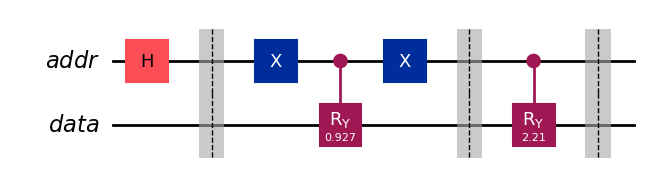

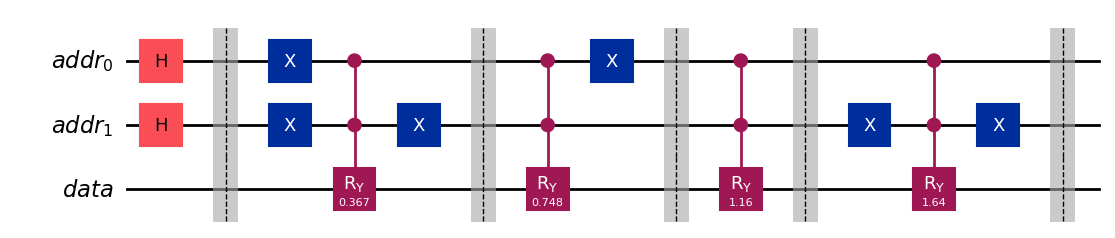

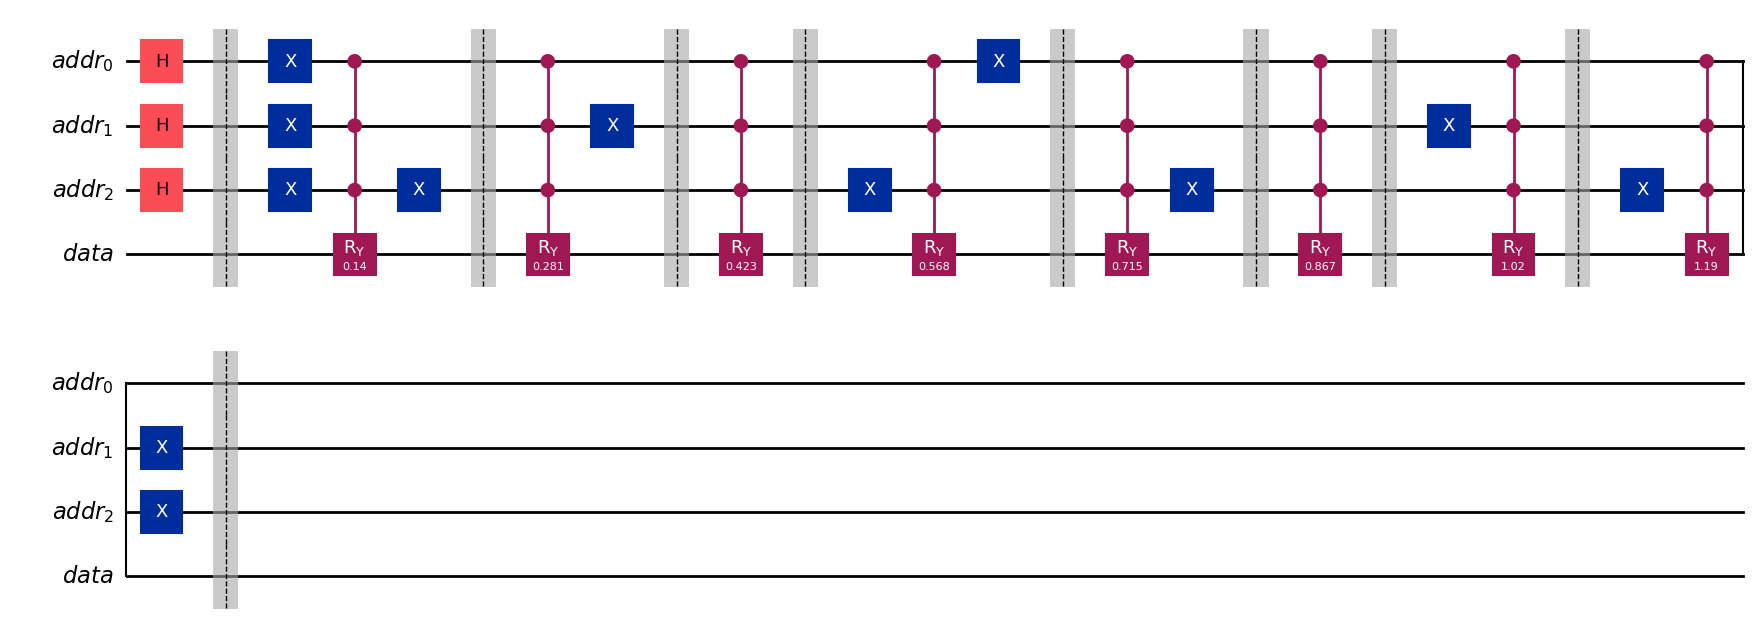

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import HGate, CXGate, RYGate, XGate
from numpy import arcsin, sqrt, pi
import math
from matplotlib import pyplot as plt
from IPython.display import display
# Funzione per calcolare il valore di θ
def calculate_theta(value, max_value):
    X_N = value / sqrt(max_value)
    return 2 * arcsin(X_N)


# Funzione per generare il codice Gray
def gray_code(n):
    """Generate n-bit Gray code iteratively."""
    if n == 0:
        return ['0']
    if n == 1:
        return ['0', '1']
    
    gray_codes = ['0', '1']
    for i in range(2, n + 1):
        # Create the next sequence by reflecting the current sequence
        reflected = ['1' + code for code in reversed(gray_codes)]
        gray_codes = ['0' + code for code in gray_codes] + reflected
    
    return gray_codes


def calculate_circuit_metrics_GrayCode(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    countXGate = 0

    qaddr = QuantumRegister(n, 'addr')
    previous_bit = [1] * n
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    gray_codes = gray_code(n)
    binary_index = list(enumerate(gray_codes[0]))
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        for j, bit in binary_index:
            if bit == '0' and previous_bit[j] == 1:
                circuit.append(XGate(), [qaddr[j]])
                countXGate+=1
            previous_bit[j] = int(bit)
        
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
        
        if i < N - 1:
            binary_index = list(enumerate(gray_codes[i + 1]))
            for j, next_bit in binary_index:
                if next_bit == '1' and previous_bit[j] == 0:
                    circuit.append(XGate(), [qaddr[j]])
                    countXGate+=1
        else:
            for j, bit in binary_index:
                if bit == '0':
                    circuit.append(XGate(), [qaddr[j]])
                    countXGate+=1
        
        circuit.barrier()

    # Draw the circuit and display the number of X gates
    display(circuit.draw(output='mpl'))


dataset_size = {i for i in range(1, 4)}

for size in dataset_size:
    memory_values = [i for i in range(1, (2**size) + 1)]

    calculate_circuit_metrics_GrayCode(memory_values)


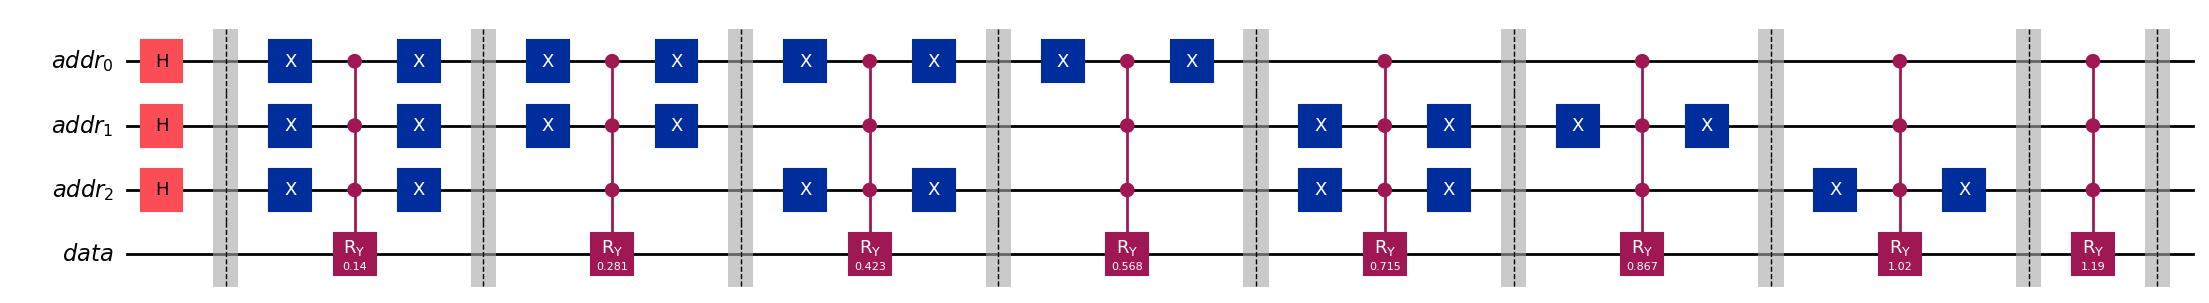

In [27]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import HGate, RYGate, XGate
from lib.circuit_metrics import calculate_theta
import math
from matplotlib import pyplot as plt




n=3
N = 2**n

memory_values = [i for i in range(1, N + 1)]
max_value = sum([x**2 for x in memory_values])

qaddr = QuantumRegister(n, 'addr')
qdata = QuantumRegister(1, 'data')
circuit = QuantumCircuit(qaddr, qdata)

for qa in qaddr:
    circuit.append(HGate(), [qa])
circuit.barrier()

for i, el in enumerate(memory_values):
    theta = calculate_theta(el, max_value)
    binary_index = bin(i)[2:].zfill(n)
    for j, bit in enumerate(binary_index):
        if bit == '0':
            circuit.append(XGate(), [qaddr[j]])
    CRYGATE = RYGate(theta).control(n)
    circuit.append(CRYGATE, qaddr[:] + [qdata[0]])
    

    for j, bit in enumerate(binary_index):
        if bit == '0':
            circuit.append(XGate(), [qaddr[j]])
    circuit.barrier()

circuit.draw(output='mpl', fold=-1)


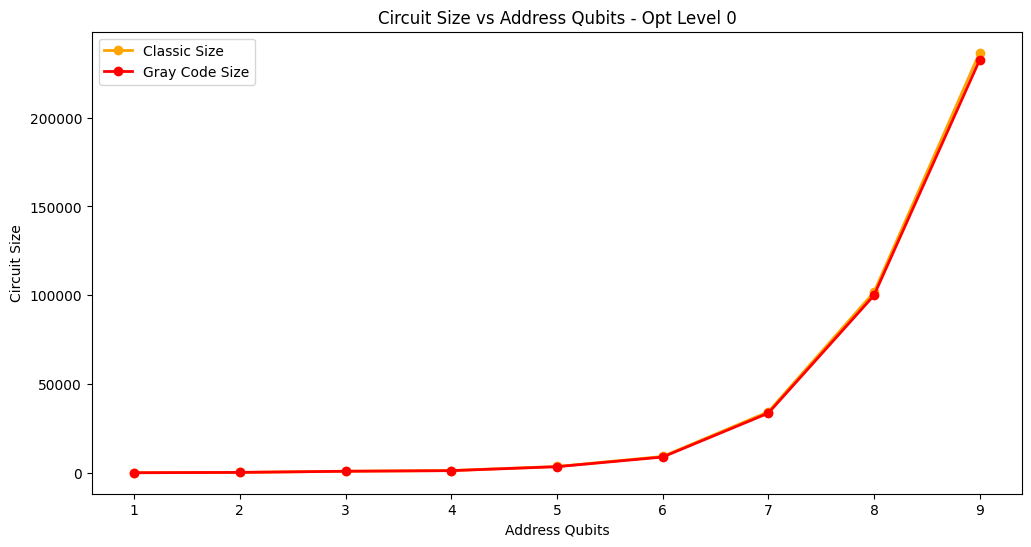

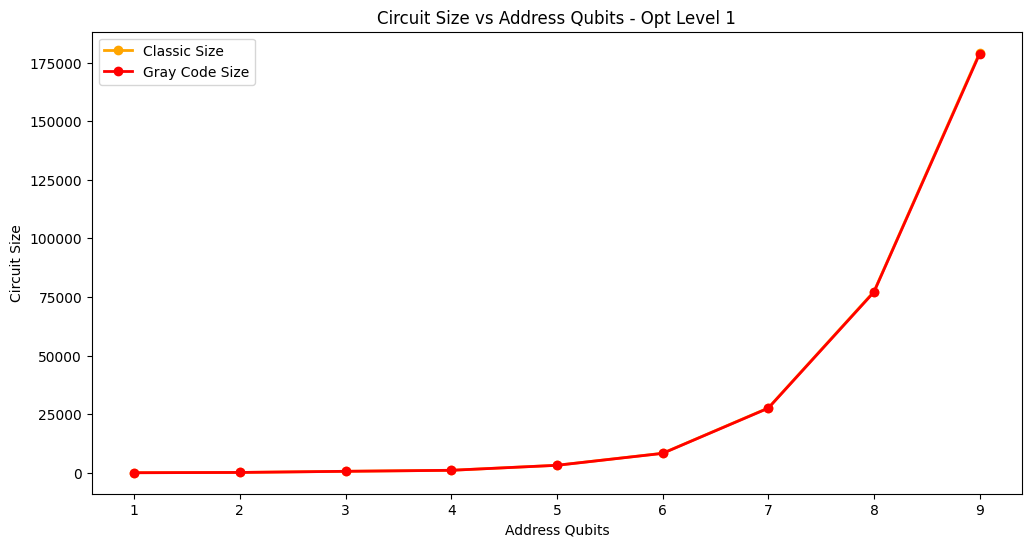

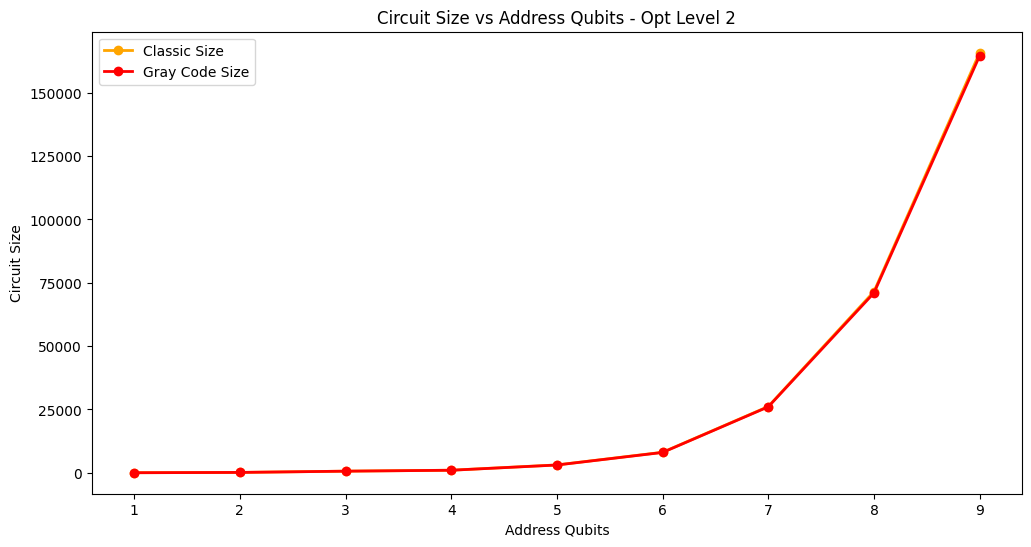

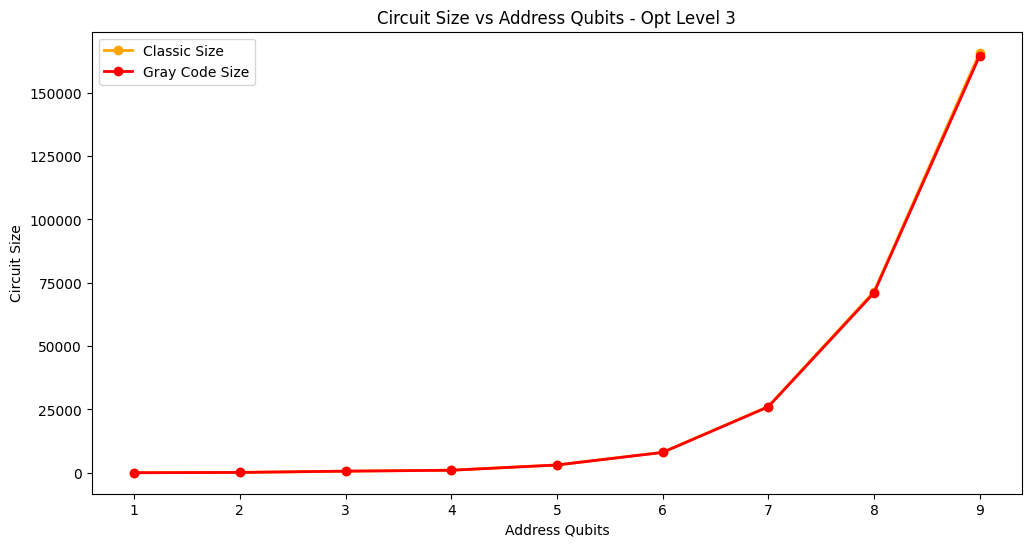

In [2]:
from lib.circuit_metrics import ffqram_metrics_graycode, ffqram_metrics_classic
from matplotlib import pyplot as plt

size = range(1,10)

classic_opt_size = []
gray_opt_size = []


for i in range(0,4):
    for el in size:
        _, _ , _ , classic_size , _ , _ = ffqram_metrics_classic(el, barrier=False, opt_lvl=i)
        _, _ , _ , gray_size , _ , _ = ffqram_metrics_graycode(el, barrier=False, opt_lvl=i)

        classic_opt_size.append(classic_size)
        gray_opt_size.append(gray_size)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Address Qubits')
    plt.ylabel('Circuit Size')
    plt.title(f'Circuit Size vs Address Qubits - Opt Level {i}')
    plt.plot(size, classic_opt_size, marker='o', color='orange', linewidth=2, label='Classic Size')
    plt.plot(size, gray_opt_size, marker='o', color='red', linewidth=2, label='Gray Code Size')
    plt.legend()
    plt.show()
    classic_opt_size = []
    gray_opt_size = []

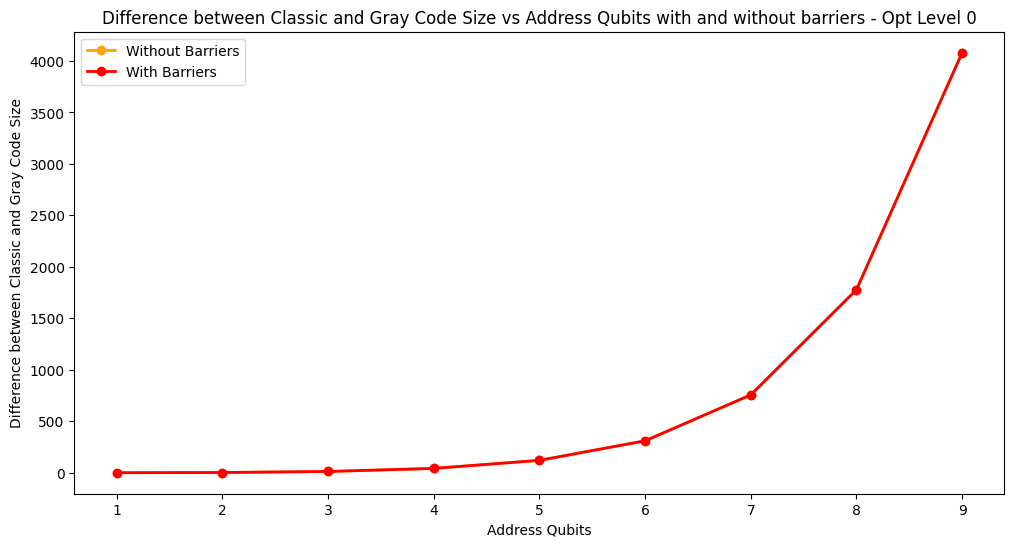

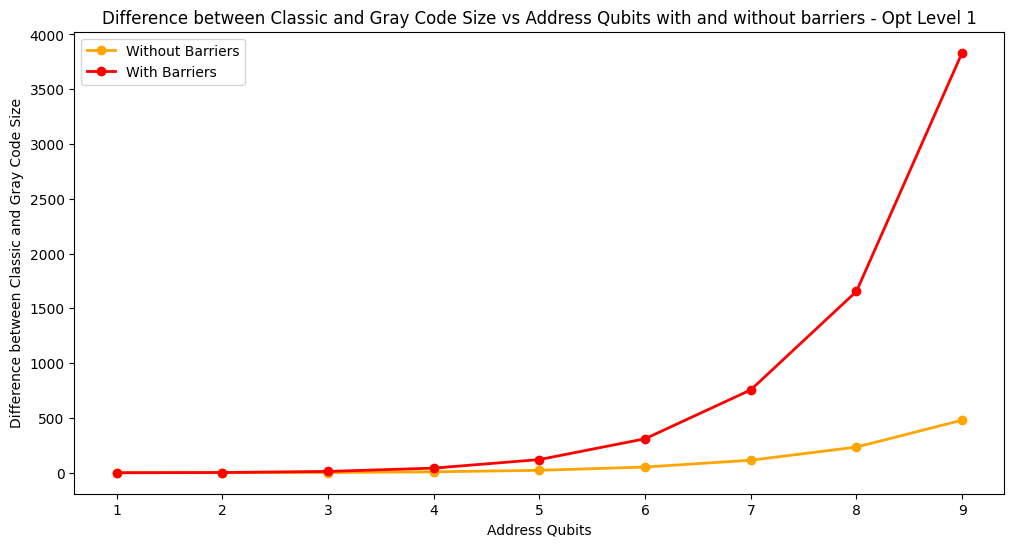

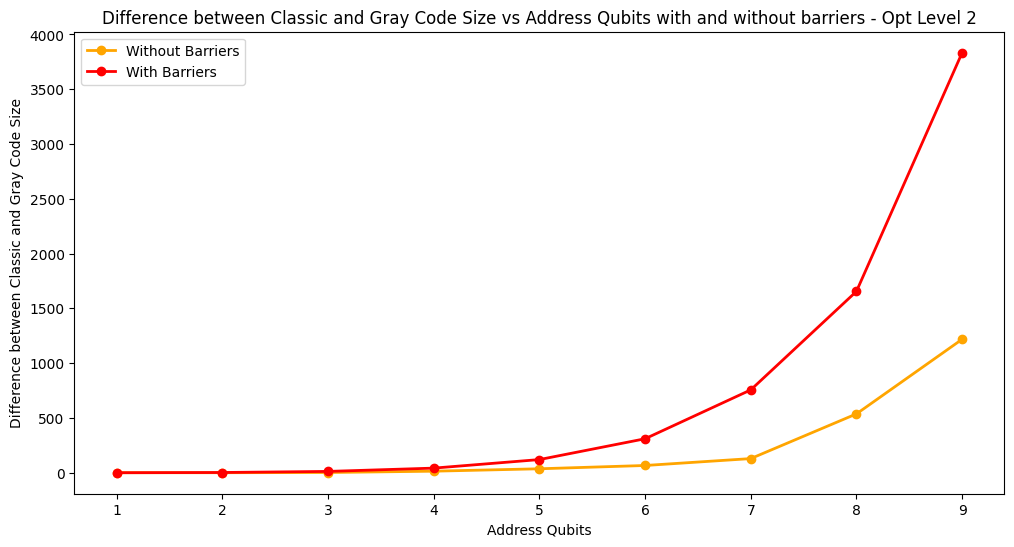

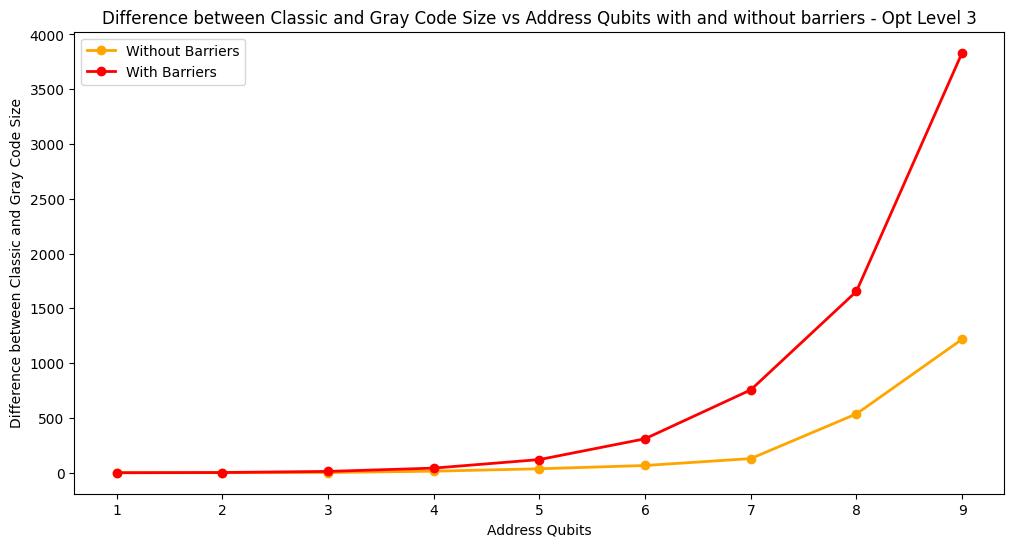

In [4]:

size = range(1,10)

difference_b_size = []
difference_size = []


with open("output.txt", "w") as file:
    for i in range(0, 4):
        file.write(f"Opt Level {i}\n")
        for el in size:
            _, _, _, classic_size, _, _ = ffqram_metrics_classic(el, barrier=False, opt_lvl=i)
            _, _, _, gray_size, _, _ = ffqram_metrics_graycode(el, barrier=False, opt_lvl=i)

            difference_size.append(classic_size - gray_size)

            _, _, _, classic_b_size, _, _ = ffqram_metrics_classic(el, barrier=True, opt_lvl=i)
            _, _, _, gray_b_size, _, _ = ffqram_metrics_graycode(el, barrier=True, opt_lvl=i)

            difference_b_size.append(classic_b_size - gray_b_size)
            file.write(f"Number of address qubits: {el}\n")
            file.write(f"Classic Size: {classic_size}\n")
            file.write(f"Gray Code Size: {gray_size}\n")
            file.write(f"Classic Size with Barriers: {classic_b_size}\n")
            file.write(f"Gray Code Size with Barriers: {gray_b_size}\n")
            file.write(f"Difference between Classic and Gray Code Size: {classic_size - gray_size}\n")
            file.write(f"Difference between Classic and Gray Code Size with Barriers: {classic_b_size - gray_b_size}\n")

        plt.figure(figsize=(12, 6))
        plt.xlabel('Address Qubits')
        plt.ylabel("Difference between Classic and Gray Code Size")
        plt.title(f'Difference between Classic and Gray Code Size vs Address Qubits with and without barriers - Opt Level {i}')
        plt.plot(size, difference_size, marker='o', color='orange', linewidth=2, label='Without Barriers')
        plt.plot(size, difference_b_size, marker='o', color='red', linewidth=2, label='With Barriers')
        plt.legend()
        plt.show()

        difference_size = []
        difference_b_size = []


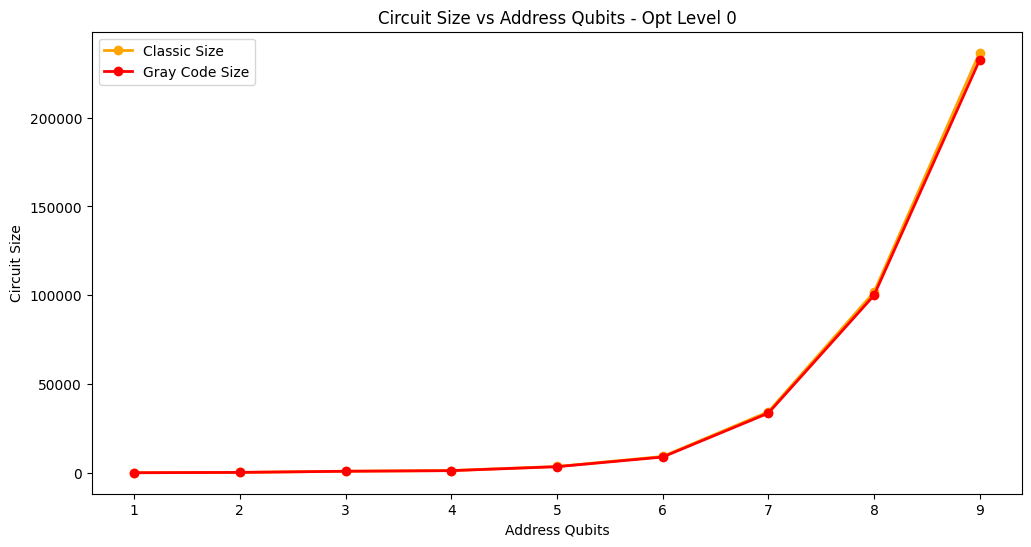

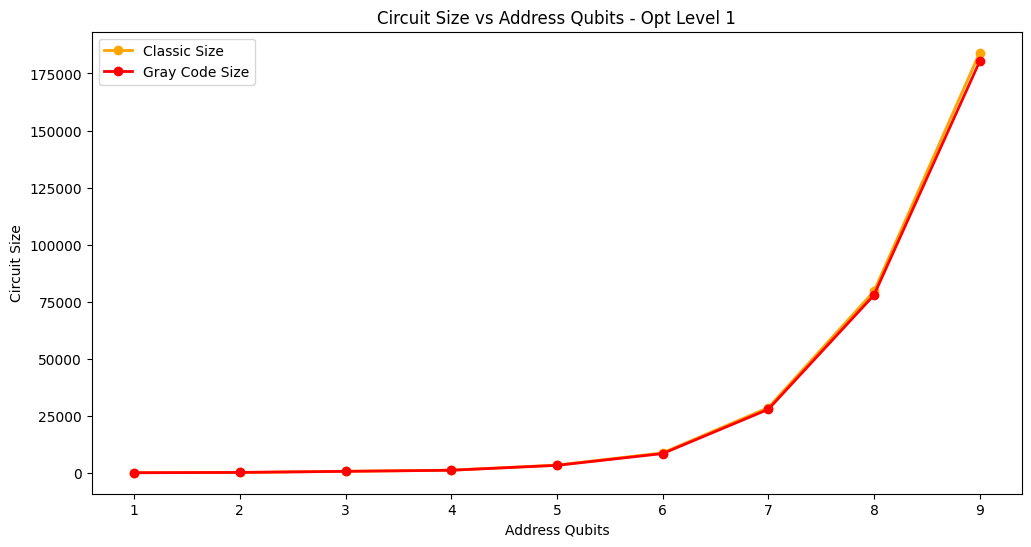

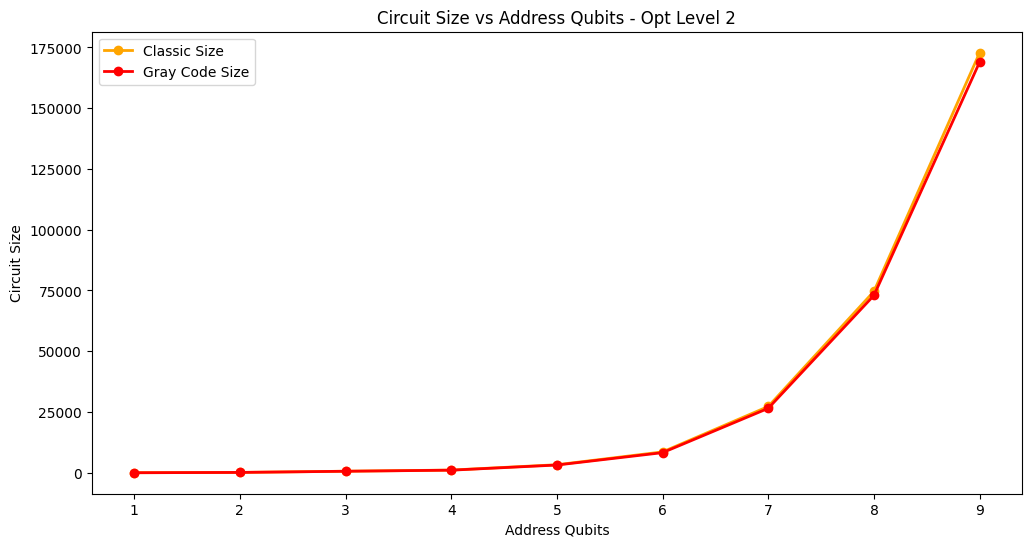

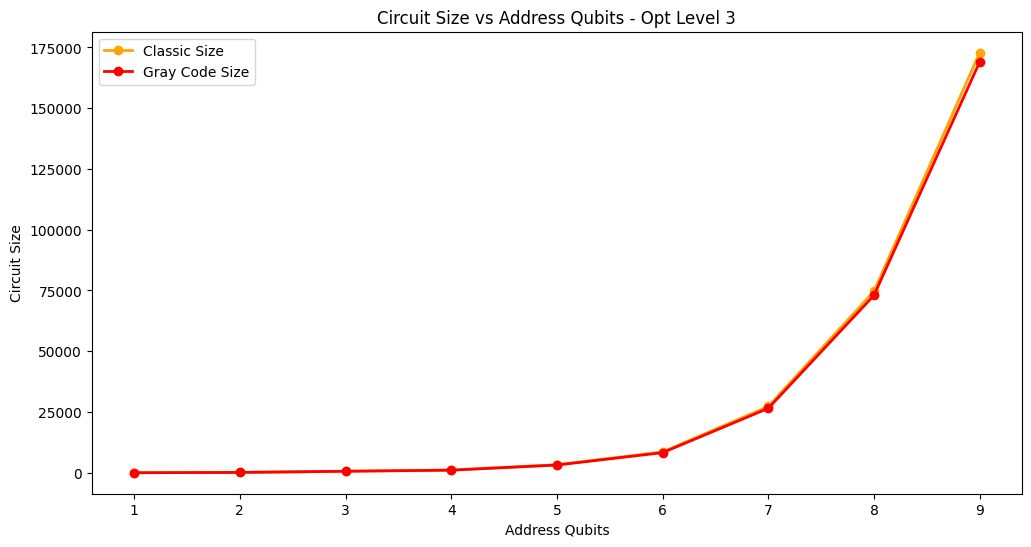

In [5]:
from lib.circuit_metrics import ffqram_metrics_graycode, ffqram_metrics_classic
from matplotlib import pyplot as plt

size = range(1,10)

classic_opt_size = []
gray_opt_size = []


for i in range(0,4):
    for el in size:
        _, _ , _ , classic_size , _ , _ = ffqram_metrics_classic(el, barrier=True, opt_lvl=i)
        _, _ , _ , gray_size , _ , _ = ffqram_metrics_graycode(el, barrier=True, opt_lvl=i)

        classic_opt_size.append(classic_size)
        gray_opt_size.append(gray_size)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Address Qubits')
    plt.ylabel('Circuit Size')
    plt.title(f'Circuit Size vs Address Qubits - Opt Level {i}')
    plt.plot(size, classic_opt_size, marker='o', color='orange', linewidth=2, label='Classic Size',)
    plt.plot(size, gray_opt_size, marker='o', color='red', linewidth=2, label='Gray Code Size')
    plt.legend()
    plt.show()
    classic_opt_size = []
    gray_opt_size = []

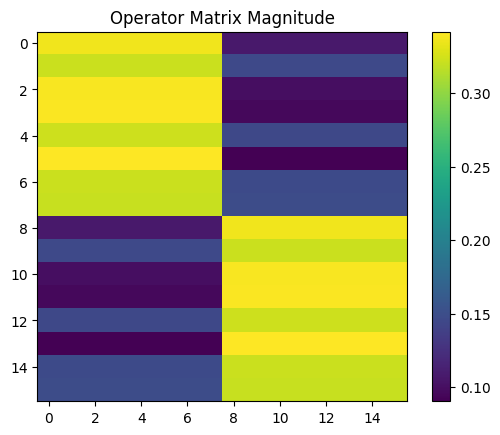

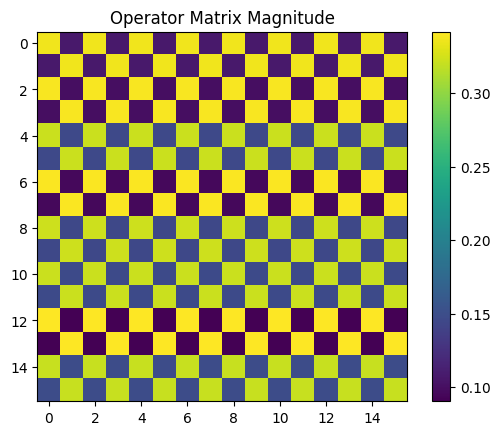

In [ ]:
from lib.circuit_metrics import create_ffqram_gc_circuit
import numpy as np
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt

def main():
    n = 3  # You can change this value as needed
    array_size = 2 ** n
    random_array = np.random.rand(array_size)

    op_circuit, circuit = create_ffqram_gc_circuit(n, memory_values=random_array, opt_lvl=2)

    operator_matrix = Operator(circuit).data

    op_matrix = Operator(op_circuit)

    # Plot the Operator Matrix

    plt.imshow(np.abs(operator_matrix), cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('Operator Matrix Magnitude')
    plt.show()


    # Plot the Operator Matrix

    plt.imshow(np.abs(op_matrix), cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('Operator Matrix Magnitude')
    plt.show()







if __name__ == "__main__":
    main()


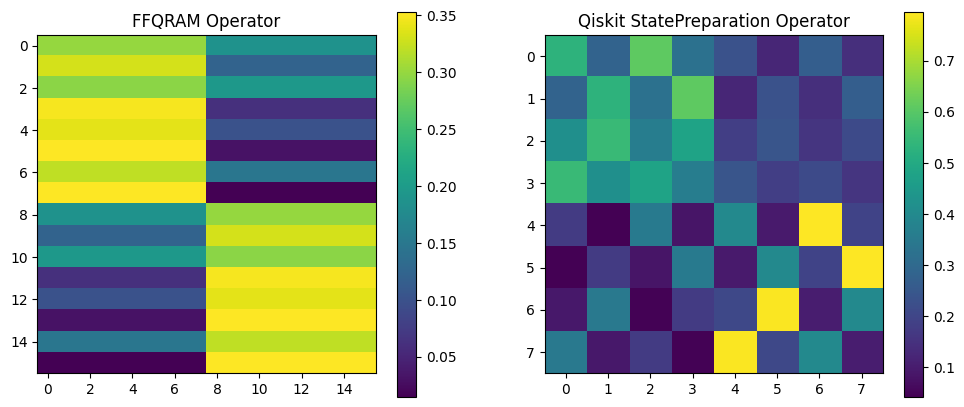

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.circuit.library import StatePreparation
from qiskit import QuantumCircuit

# Funzione per plottare due matrici affiancate
def plot_matrices(matrix1, matrix2, title1="FFQRAM Operator", title2="Qiskit StatePreparation Operator"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Prima matrice (FFQRAM)
    im1 = axes[0].imshow(np.abs(matrix1), cmap='viridis', interpolation='none')
    axes[0].set_title(title1)
    plt.colorbar(im1, ax=axes[0])

    # Seconda matrice (StatePreparation)
    im2 = axes[1].imshow(np.abs(matrix2), cmap='viridis', interpolation='none')
    axes[1].set_title(title2)
    plt.colorbar(im2, ax=axes[1])

    plt.show()


# Numero di qubit
n = 3
array_size = 2 ** n

# Generiamo un array casuale e lo normalizziamo
random_array = np.random.rand(array_size)
max_value = sum([x**2 for x in random_array])  # Normalizzazione
state_array = [x / np.sqrt(max_value) for x in random_array]

# **Genera la FFQRAM**
_, circuit = create_ffqram_gc_circuit(n, memory_values=random_array, opt_lvl=2)
operator_matrix_ffqram = Operator(circuit).data  # Matrice dell'operatore FFQRAM

# **Genera la matrice dell'operatore Qiskit (StatePreparation)**
state_prep_gate = StatePreparation(state_array)  # Usa StatePreparation invece di Initialize
qc = QuantumCircuit(n)
qc.append(state_prep_gate, range(n))

operator_matrix_qiskit = Operator(qc).data  # Ora possiamo calcolare l'operatore senza errori

# **Plot delle due matrici**
plot_matrices(operator_matrix_ffqram, operator_matrix_qiskit)



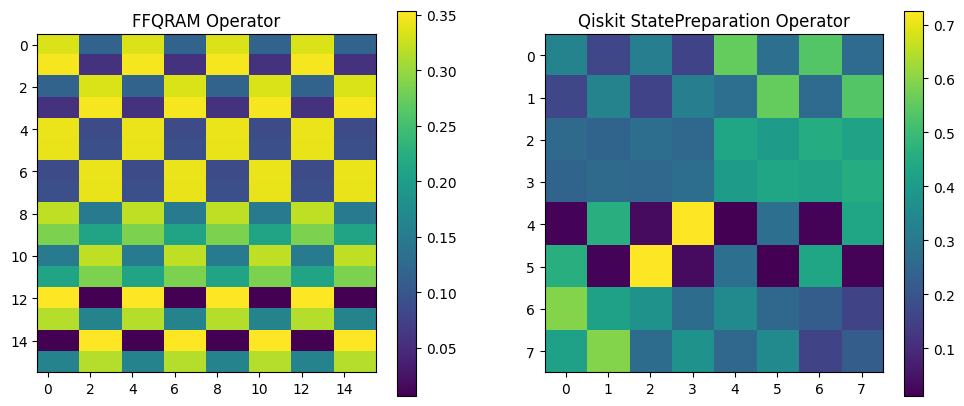

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.circuit.library import StatePreparation
from qiskit import QuantumCircuit

# Funzione per plottare due matrici affiancate
def plot_matrices(matrix1, matrix2, title1="FFQRAM Operator", title2="Qiskit StatePreparation Operator"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Prima matrice (FFQRAM)
    im1 = axes[0].imshow(np.abs(matrix1), cmap='viridis', interpolation='none')
    axes[0].set_title(title1)
    plt.colorbar(im1, ax=axes[0])

    # Seconda matrice (StatePreparation)
    im2 = axes[1].imshow(np.abs(matrix2), cmap='viridis', interpolation='none')
    axes[1].set_title(title2)
    plt.colorbar(im2, ax=axes[1])

    plt.show()


# Numero di qubit
n = 3
array_size = 2 ** n

# Generiamo un array casuale e lo normalizziamo
random_array = np.random.rand(array_size)
max_value = sum([x**2 for x in random_array])  # Normalizzazione
state_array = [x / np.sqrt(max_value) for x in random_array]

# **Genera la FFQRAM**
circuit, _ = create_ffqram_gc_circuit(n, memory_values=random_array, opt_lvl=2)
operator_matrix_ffqram = Operator(circuit).data  # Matrice dell'operatore FFQRAM

# **Genera la matrice dell'operatore Qiskit (StatePreparation)**
state_prep_gate = StatePreparation(state_array)  # Usa StatePreparation invece di Initialize
qc = QuantumCircuit(n)
qc.append(state_prep_gate, range(n))

operator_matrix_qiskit = Operator(qc).data  # Ora possiamo calcolare l'operatore senza errori

# **Plot delle due matrici**
plot_matrices(operator_matrix_ffqram, operator_matrix_qiskit)


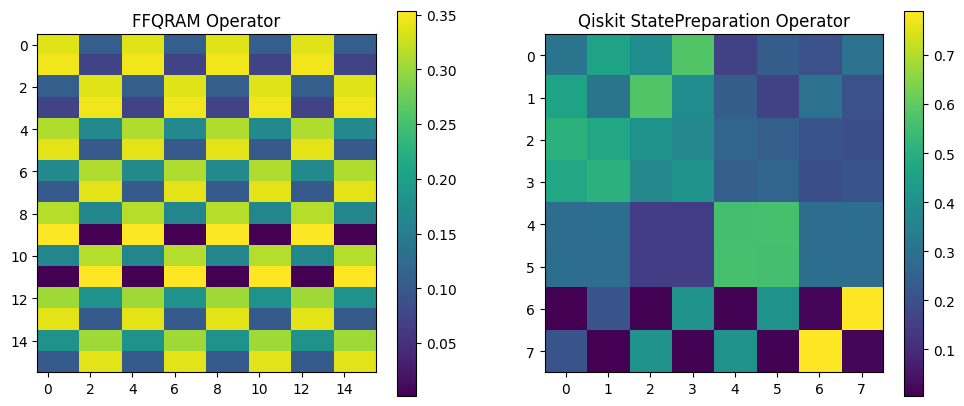

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Operator
from qiskit.circuit.library import Initialize
from qiskit import QuantumCircuit

# Funzione per plottare due matrici affiancate
def plot_matrices(matrix1, matrix2, title1="FFQRAM Operator", title2="Qiskit StatePreparation Operator"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Prima matrice (FFQRAM)
    im1 = axes[0].imshow(np.abs(matrix1), cmap='viridis', interpolation='none')
    axes[0].set_title(title1)
    plt.colorbar(im1, ax=axes[0])

    # Seconda matrice (StatePreparation)
    im2 = axes[1].imshow(np.abs(matrix2), cmap='viridis', interpolation='none')
    axes[1].set_title(title2)
    plt.colorbar(im2, ax=axes[1])

    plt.show()


# Numero di qubit
n = 3
array_size = 2 ** n

# Generiamo un array casuale e lo normalizziamo
random_array = np.random.rand(array_size)
max_value = sum([x**2 for x in random_array])  # Normalizzazione
state_array = [x / np.sqrt(max_value) for x in random_array]

# **Genera la FFQRAM**
circuit, _ = create_ffqram_gc_circuit(n, memory_values=random_array, opt_lvl=2)
operator_matrix_ffqram = Operator(circuit).data  # Matrice dell'operatore FFQRAM

# **Genera la matrice dell'operatore Qiskit (StatePreparation)**
init = Initialize(state_array)  # Usa Initialize invece di StatePreparation

operator_matrix_qiskit = Operator(init._stateprep)  # Ora possiamo calcolare l'operatore senza errori

# **Plot delle due matrici**
# Plot the matrices
plot_matrices(operator_matrix_ffqram, operator_matrix_qiskit)


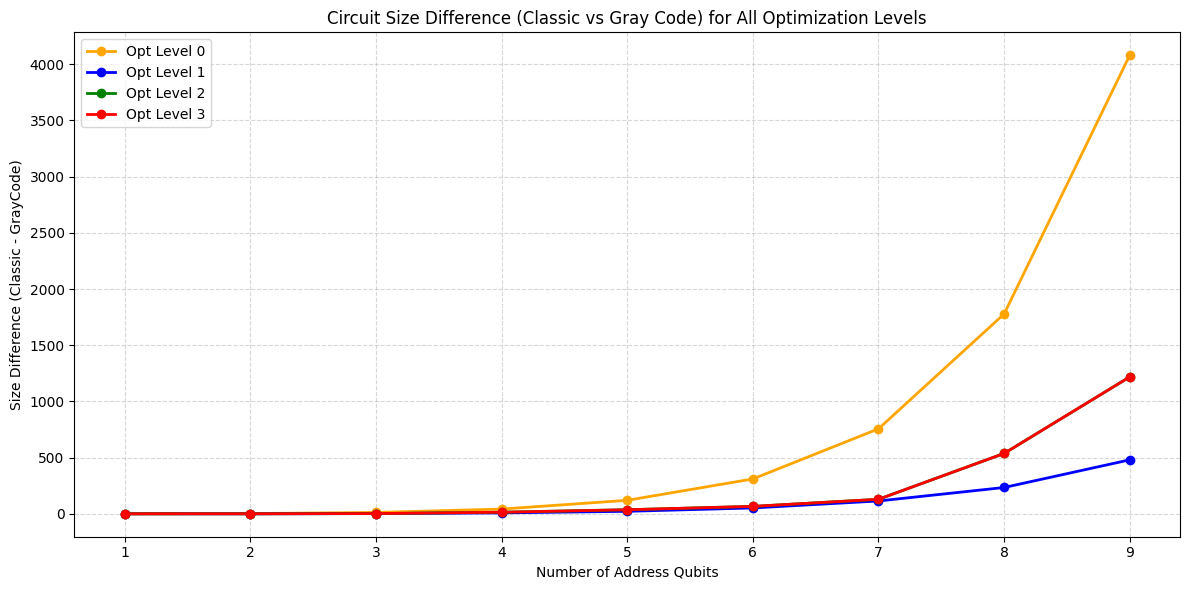

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Carica i dati dal file JSON
file_path = "circuit_metrics_data.json"

with open(file_path, "r") as f:
    data = json.load(f)

# Lista dei livelli di ottimizzazione ordinati
opt_levels = sorted(map(int, data.keys()))  # Converti le chiavi in interi e ordina
address_qubits = data["0"]["no_barriers"]["address_qubits"]  # Lista dei qubits (valida per tutti)

# Definizione colori per il confronto
colors = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red"
}

# Creazione del grafico unico
plt.figure(figsize=(12, 6))

# 🔄 Itera su ogni livello di ottimizzazione per aggiungere le curve al grafico
for opt in opt_levels:
    # Estrai i dati di size per Classic e Gray Code senza barriere
    classic_no_barrier = np.array(data[str(opt)]["no_barriers"]["classic"]["optimized_size"])
    gray_no_barrier = np.array(data[str(opt)]["no_barriers"]["graycode"]["optimized_size"])

    # Calcola la differenza di size tra Classic e Gray Code
    diff_no_barrier = classic_no_barrier - gray_no_barrier

    # Aggiungi la curva al grafico
    plt.plot(address_qubits, diff_no_barrier, marker='o', linestyle='-', linewidth=2, 
             color=colors[opt], label=f"Opt Level {opt}")

# Impostazioni del grafico
plt.xlabel("Number of Address Qubits")
plt.ylabel("Size Difference (Classic - GrayCode)")
plt.title("Circuit Size Difference (Classic vs Gray Code) for All Optimization Levels")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


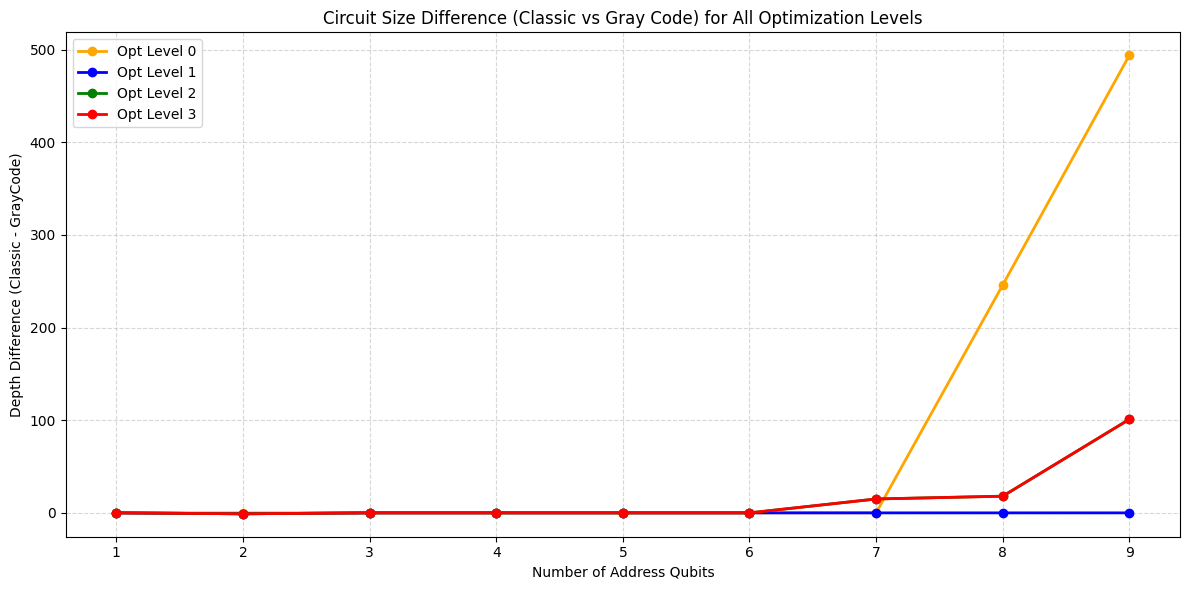

In [47]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Carica i dati dal file JSON
file_path = "circuit_metrics_data.json"

with open(file_path, "r") as f:
    data = json.load(f)

# Lista dei livelli di ottimizzazione ordinati
opt_levels = sorted(map(int, data.keys()))  # Converti le chiavi in interi e ordina
address_qubits = data["0"]["no_barriers"]["address_qubits"]  # Lista dei qubits (valida per tutti)

# Definizione colori per il confronto
colors = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red"
}

# Creazione del grafico unico
plt.figure(figsize=(12, 6))

# 🔄 Itera su ogni livello di ottimizzazione per aggiungere le curve al grafico
for opt in opt_levels:
    # Estrai i dati di size per Classic e Gray Code senza barriere
    classic_no_barrier = np.array(data[str(opt)]["no_barriers"]["classic"]["optimized_depth"])
    gray_no_barrier = np.array(data[str(opt)]["no_barriers"]["graycode"]["optimized_depth"])

    # Calcola la differenza di size tra Classic e Gray Code
    diff_no_barrier = classic_no_barrier - gray_no_barrier

    # Aggiungi la curva al grafico
    plt.plot(address_qubits, diff_no_barrier, marker='o', linestyle='-', linewidth=2, 
             color=colors[opt], label=f"Opt Level {opt}")

# Impostazioni del grafico
plt.xlabel("Number of Address Qubits")
plt.ylabel("Depth Difference (Classic - GrayCode)")
plt.title("Circuit Size Difference (Classic vs Gray Code) for All Optimization Levels")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

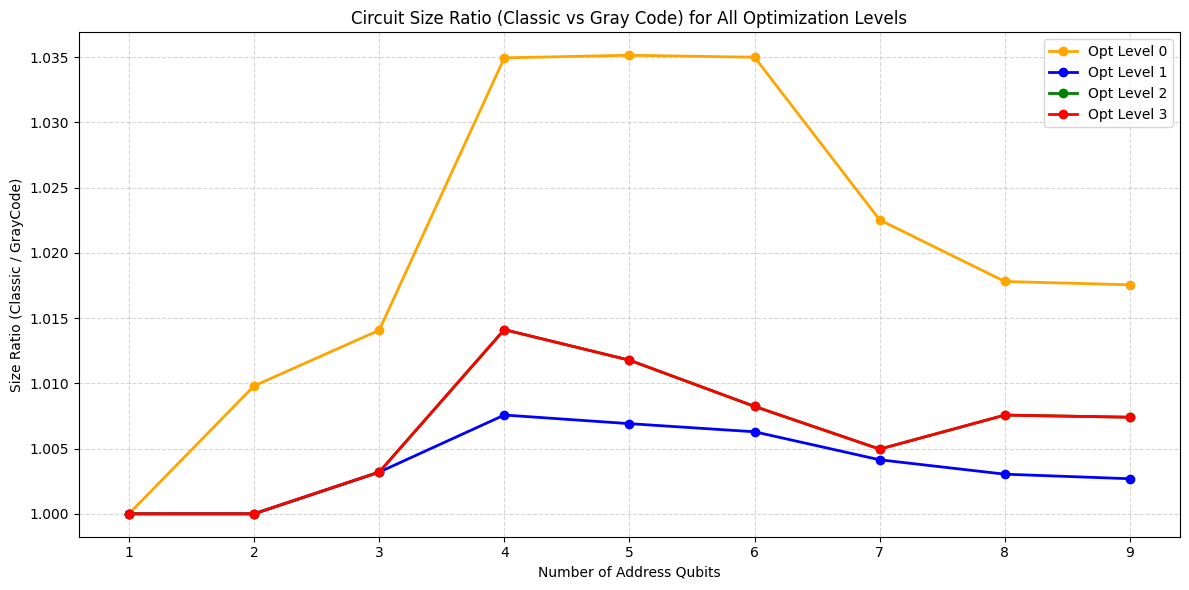

In [21]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Carica i dati dal file JSON
file_path = "circuit_metrics_data.json"

with open(file_path, "r") as f:
    data = json.load(f)

# Lista dei livelli di ottimizzazione ordinati
opt_levels = sorted(map(int, data.keys()))  # Converti le chiavi in interi e ordina
address_qubits = data["0"]["no_barriers"]["address_qubits"]  # Lista dei qubits (valida per tutti)

# Definizione colori per il confronto
colors = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red"
}

# Creazione del grafico unico
plt.figure(figsize=(12, 6))

# 🔄 Itera su ogni livello di ottimizzazione per aggiungere le curve al grafico
for opt in opt_levels:
    # 
    # 
    # 
    # Estrai i dati di size per Classic e Gray Code senza barriere
    classic_no_barrier = np.array(data[str(opt)]["no_barriers"]["classic"]["optimized_size"])
    gray_no_barrier = np.array(data[str(opt)]["no_barriers"]["graycode"]["optimized_size"])

    # Calcola il rapporto tra Classic e Gray Code
    ratio_no_barrier = classic_no_barrier / gray_no_barrier

    # Aggiungi la curva al grafico
    plt.plot(address_qubits, ratio_no_barrier, marker='o', linestyle='-', linewidth=2, 
             color=colors[opt], label=f"Opt Level {opt}")

# Impostazioni del grafico
plt.xlabel("Number of Address Qubits")
plt.ylabel("Size Ratio (Classic / GrayCode)")
plt.title("Circuit Size Ratio (Classic vs Gray Code) for All Optimization Levels")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


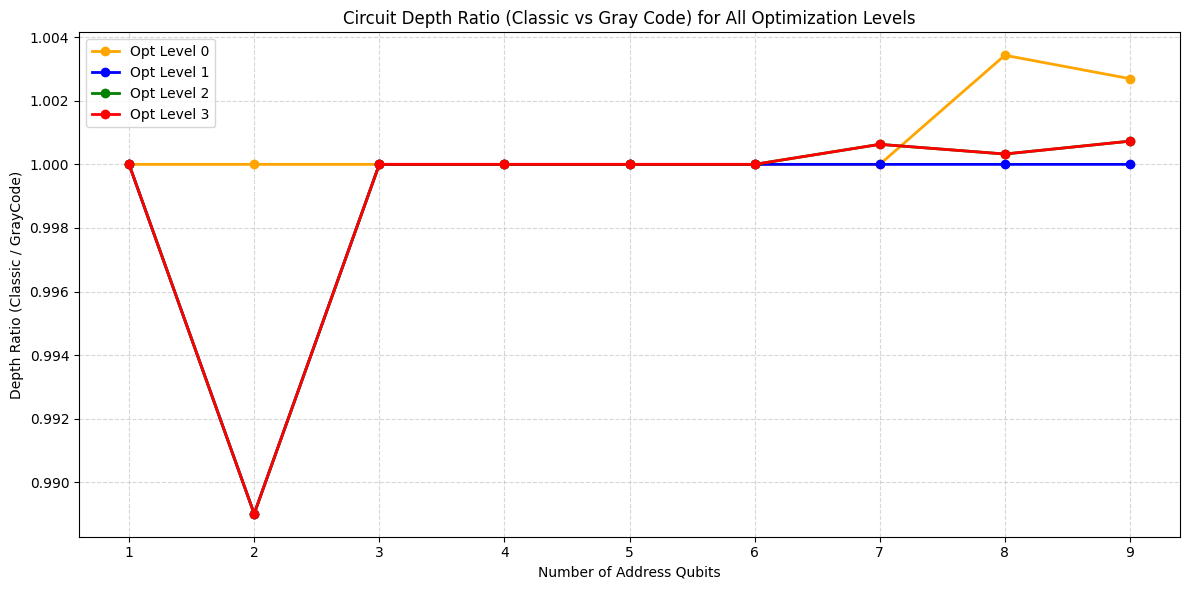

In [44]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Carica i dati dal file JSON
file_path = "data/circuit_metrics_data.json"

with open(file_path, "r") as f:
    data = json.load(f)

# Lista dei livelli di ottimizzazione ordinati
opt_levels = sorted(map(int, data.keys()))  # Converti le chiavi in interi e ordina
address_qubits = data["0"]["no_barriers"]["address_qubits"]  # Lista dei qubits (valida per tutti)

# Definizione colori per il confronto
colors = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red"
}

# Creazione del grafico unico
plt.figure(figsize=(12, 6))

# 🔄 Itera su ogni livello di ottimizzazione per aggiungere le curve al grafico
for opt in opt_levels:
    # 
    # 
    # 
    # Estrai i dati di size per Classic e Gray Code senza barriere
    classic_no_barrier = np.array(data[str(opt)]["no_barriers"]["classic"]["optimized_depth"])
    gray_no_barrier = np.array(data[str(opt)]["no_barriers"]["graycode"]["optimized_depth"])

    # Calcola il rapporto tra Classic e Gray Code
    ratio_no_barrier = classic_no_barrier / gray_no_barrier

    # Aggiungi la curva al grafico
    plt.plot(address_qubits, ratio_no_barrier, marker='o', linestyle='-', linewidth=2, 
             color=colors[opt], label=f"Opt Level {opt}")

# Impostazioni del grafico
plt.xlabel("Number of Address Qubits")
plt.ylabel("Depth Ratio (Classic / GrayCode)")
plt.title("Circuit Depth Ratio (Classic vs Gray Code) for All Optimization Levels")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

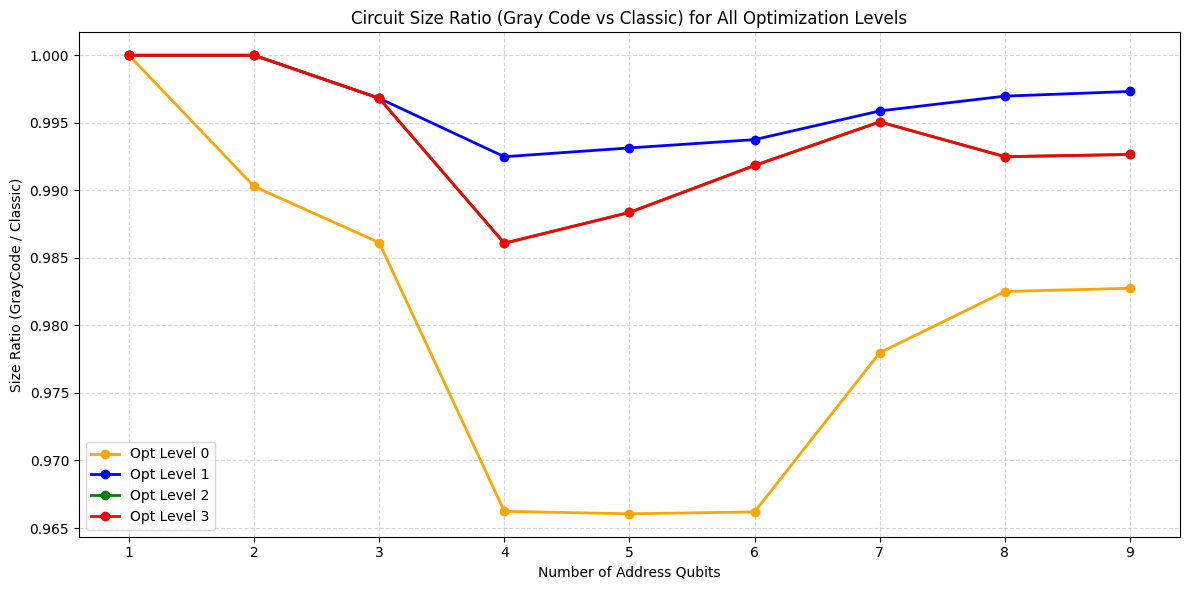

In [22]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Carica i dati dal file JSON
file_path = "circuit_metrics_data.json"

with open(file_path, "r") as f:
    data = json.load(f)

# Lista dei livelli di ottimizzazione ordinati
opt_levels = sorted(map(int, data.keys()))  # Converti le chiavi in interi e ordina
address_qubits = data["0"]["no_barriers"]["address_qubits"]  # Lista dei qubits (valida per tutti)

# Definizione colori per il confronto
colors = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red"
}

# Creazione del grafico unico
plt.figure(figsize=(12, 6))

# 🔄 Itera su ogni livello di ottimizzazione per aggiungere le curve al grafico
for opt in opt_levels:
    # Estrai i dati di size per Classic e Gray Code senza barriere
    classic_no_barrier = np.array(data[str(opt)]["no_barriers"]["classic"]["optimized_size"])
    gray_no_barrier = np.array(data[str(opt)]["no_barriers"]["graycode"]["optimized_size"])

    # Calcola il rapporto tra Gray Code e Classic
    ratio_no_barrier = gray_no_barrier / classic_no_barrier

    # Aggiungi la curva al grafico
    plt.plot(address_qubits, ratio_no_barrier, marker='o', linestyle='-', linewidth=2, 
             color=colors[opt], label=f"Opt Level {opt}")

# Impostazioni del grafico
plt.xlabel("Number of Address Qubits")
plt.ylabel("Size Ratio (GrayCode / Classic)")
plt.title("Circuit Size Ratio (Gray Code vs Classic) for All Optimization Levels")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()







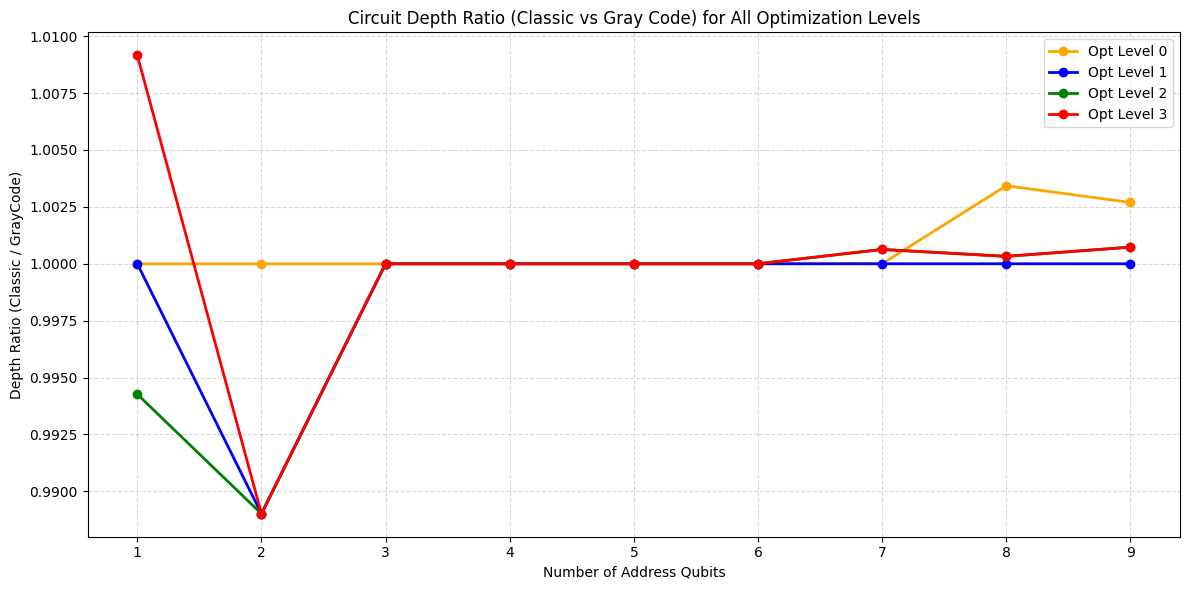

In [1]:
# Ricarichiamo il file JSON dopo la conferma della struttura
import json
import matplotlib.pyplot as plt
import numpy as np

# Percorso del file JSON
json_file_path = "data/metrics_summary.json"

# Carica i dati dal file JSON
with open(json_file_path, "r") as f:
    metrics_data = json.load(f)

# Lista dei livelli di ottimizzazione ordinati
opt_levels = sorted(map(int, metrics_data.keys()))  # Converti le chiavi in interi e ordina
address_qubits = sorted(map(int, metrics_data["0"].keys()))  # Lista dei qubits (valida per tutti)

# Definizione colori per il confronto
colors = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red"
}

# Creazione del grafico unico
plt.figure(figsize=(12, 6))

# 🔄 Itera su ogni livello di ottimizzazione per aggiungere le curve al grafico
for opt in opt_levels:
    # Estrai i dati di depth per Classic e Gray Code
    classic_depths = np.array([metrics_data[str(opt)][str(n)]["avg_classic_depth"] for n in address_qubits])
    gray_depths = np.array([metrics_data[str(opt)][str(n)]["avg_gray_depth"] for n in address_qubits])

    # Calcola il rapporto tra Classic e Gray Code
    ratio_depth = classic_depths / gray_depths

    # Aggiungi la curva al grafico
    plt.plot(address_qubits, ratio_depth, marker='o', linestyle='-', linewidth=2, 
             color=colors[opt], label=f"Opt Level {opt}")

# Impostazioni del grafico
plt.xlabel("Number of Address Qubits")
plt.ylabel("Depth Ratio (Classic / GrayCode)")
plt.title("Circuit Depth Ratio (Classic vs Gray Code) for All Optimization Levels")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


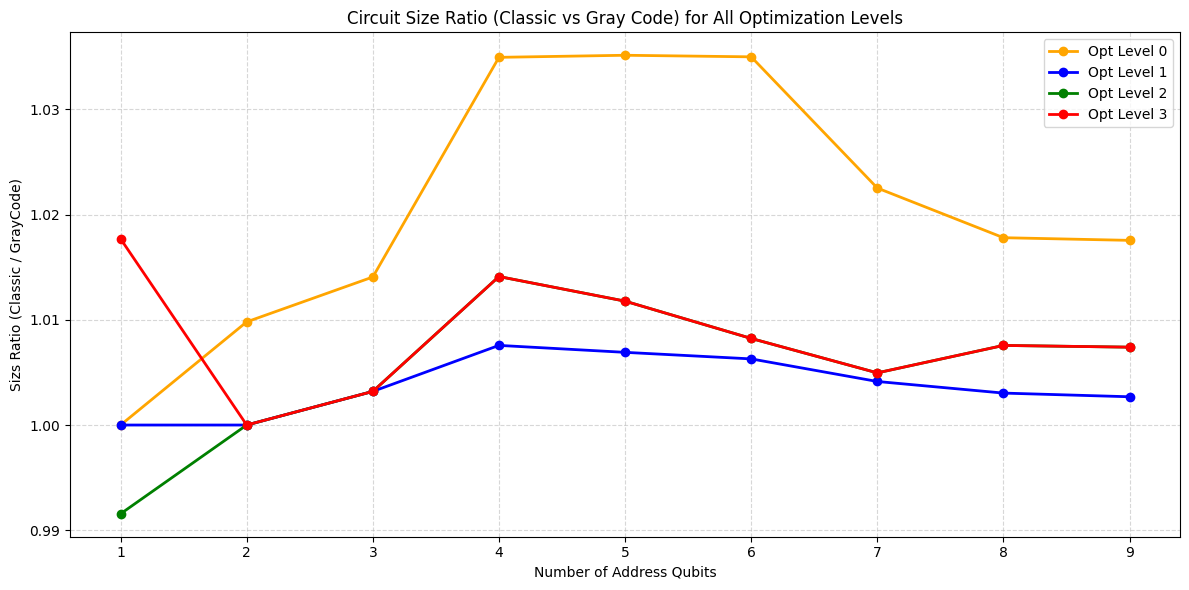

In [ ]:
# Ricarichiamo il file JSON dopo la conferma della struttura
import json
import matplotlib.pyplot as plt
import numpy as np

# Percorso del file JSON
json_file_path = "data/metrics_summary.json"

# Carica i dati dal file JSON
with open(json_file_path, "r") as f:
    metrics_data = json.load(f)

# Lista dei livelli di ottimizzazione ordinati
opt_levels = sorted(map(int, metrics_data.keys()))  # Converti le chiavi in interi e ordina
address_qubits = sorted(map(int, metrics_data["0"].keys()))  # Lista dei qubits (valida per tutti)

# Definizione colori per il confronto
colors = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red"
}

# Creazione del grafico unico
plt.figure(figsize=(12, 6))

# 🔄 Itera su ogni livello di ottimizzazione per aggiungere le curve al grafico
for opt in opt_levels:
    # Estrai i dati di depth per Classic e Gray Code
    classic_depths = np.array([metrics_data[str(opt)][str(n)]["avg_classic_size"] for n in address_qubits])
    gray_depths = np.array([metrics_data[str(opt)][str(n)]["avg_gray_size"] for n in address_qubits])

    # Calcola il rapporto tra Classic e Gray Code
    ratio_depth = classic_depths / gray_depths

    # Aggiungi la curva al grafico
    plt.plot(address_qubits, ratio_depth, marker='o', linestyle='-', linewidth=2, 
             color=colors[opt], label=f"Opt Level {opt}")

# Impostazioni del grafico
plt.xlabel("Number of Address Qubits")
plt.ylabel("Size Ratio (Classic / GrayCode)")
plt.title("Circuit Size Ratio (Classic vs Gray Code) for All Optimization Levels")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


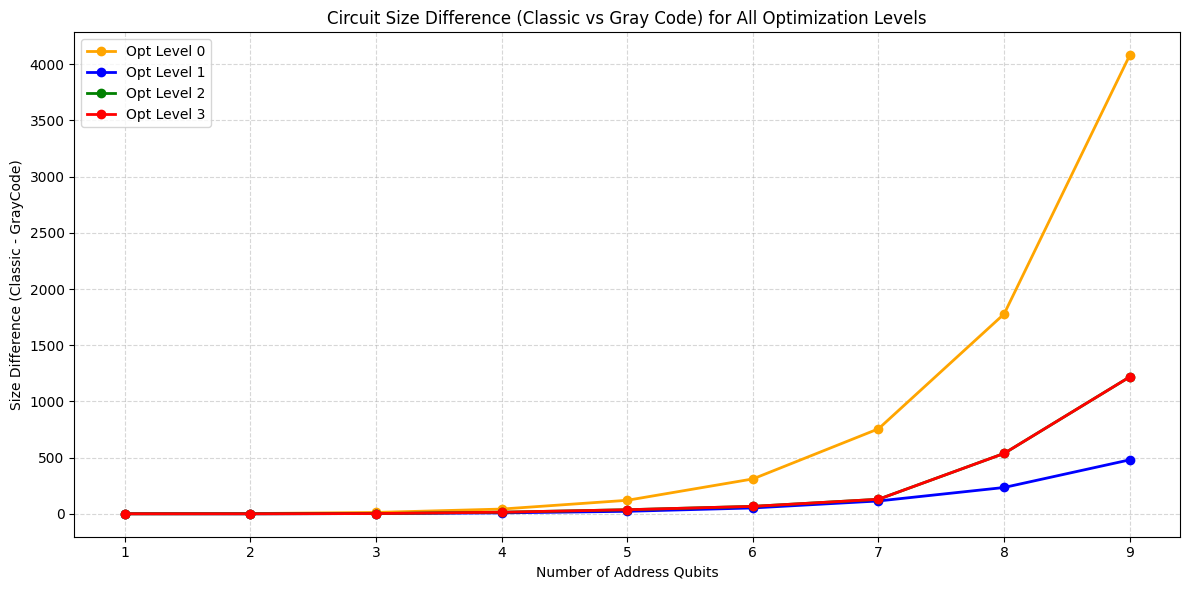

In [ ]:
# Ricarichiamo il file JSON dopo la conferma della struttura
import json
import matplotlib.pyplot as plt
import numpy as np

# Percorso del file JSON
json_file_path = "data/metrics_summary.json"

# Carica i dati dal file JSON
with open(json_file_path, "r") as f:
    metrics_data = json.load(f)

# Lista dei livelli di ottimizzazione ordinati
opt_levels = sorted(map(int, metrics_data.keys()))  # Converti le chiavi in interi e ordina

# Definizione colori per il confronto
colors = {
    0: "orange",
    1: "blue",
    2: "green",
    3: "red"
}

# Creazione del grafico unico
plt.figure(figsize=(12, 6))

# 🔄 Itera su ogni livello di ottimizzazione per aggiungere le curve al grafico
for opt in opt_levels:
    # Estrai i dati di depth per Classic e Gray Code
    classic_depths = np.array([metrics_data[str(opt)][str(n)]["avg_classic_size"] for n in address_qubits])
    gray_depths = np.array([metrics_data[str(opt)][str(n)]["avg_gray_size"] for n in address_qubits])

    # Calcola la differenza tra Classic e Gray Code
    diff_depth = classic_depths - gray_depths

    # Aggiungi la curva al grafico
    plt.plot(address_qubits, diff_depth, marker='o', linestyle='-', linewidth=2, 
             color=colors[opt], label=f"Opt Level {opt}")

# Impostazioni del grafico
plt.xlabel("Number of Address Qubits")
plt.ylabel("Size Difference (Classic - GrayCode)")
plt.title("Circuit Size Difference (Classic vs Gray Code) for All Optimization Levels")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [15]:
from lib.circuit_metrics import ffqram_metrics_graycode, create_ffqram_gc_circuit
from qiskit import QuantumCircuit
from qiskit.circuit.library import Initialize
from qiskit.transpiler import preset_passmanagers
from qiskit.providers.fake_provider import GenericBackendV2
import numpy as np
from matplotlib import pyplot as plt

# Range di qubit da testare
size = range(1, 10)

gray_size = []
init_size = []

for el in size:
    # Stato casuale e normalizzato
    random_array = np.random.rand(2**el)
    normalized_array = random_array / np.linalg.norm(random_array)

    # Initialize e decomposizione
    init_gate = Initialize(normalized_array)

    # Costruzione circuito
    qc = QuantumCircuit(el)
    qc.compose(init_gate, range(el), inplace=True)
    qc = qc.decompose()
    # Transpile con backend generico
    passmanager = preset_passmanagers.generate_preset_pass_manager(
        optimization_level=0,
        backend=GenericBackendV2(el + 1)
    )
    circuit = passmanager.run(qc)
    

    # Size del circuito initialize
    ops = circuit.count_ops()
    # print(f"CNOT with {el} qubits: {ops['cx']}")
    print(f"Initialize with {el} qubits: {ops}")
    print(f"Initialize with {el} qubits: {circuit.size()}")

    init_size.append(circuit.size())


    # FF-QRAM Graycode
    _, _, _, _, _, gray_ops = ffqram_metrics_graycode(el, barrier=False, opt_lvl=2)
    print(f"FF-QRAM Graycode with {el} qubits: {gray_ops}")





Initialize with 1 qubits: OrderedDict({'rz': 3, 'sx': 2, 'reset': 1})
Initialize with 1 qubits: 6
FF-QRAM Graycode with 1 qubits: OrderedDict({'rz': 8, 'sx': 3, 'cx': 2, 'x': 2})
Initialize with 2 qubits: OrderedDict({'rz': 9, 'sx': 6, 'reset': 2, 'cx': 1})
Initialize with 2 qubits: 18
FF-QRAM Graycode with 2 qubits: OrderedDict({'rz': 61, 'cx': 48, 'sx': 19, 'x': 4})
Initialize with 3 qubits: OrderedDict({'rz': 15, 'sx': 12, 'cx': 4, 'reset': 3})
Initialize with 3 qubits: 34
FF-QRAM Graycode with 3 qubits: OrderedDict({'rz': 230, 'sx': 227, 'cx': 160, 'x': 9})
Initialize with 4 qubits: OrderedDict({'rz': 28, 'sx': 22, 'cx': 11, 'reset': 4})
Initialize with 4 qubits: 65
FF-QRAM Graycode with 4 qubits: OrderedDict({'rz': 457, 'cx': 384, 'sx': 133, 'x': 18})
Initialize with 5 qubits: OrderedDict({'rz': 52, 'sx': 40, 'cx': 26, 'reset': 5})
Initialize with 5 qubits: 123
FF-QRAM Graycode with 5 qubits: OrderedDict({'rz': 1481, 'cx': 1280, 'sx': 262, 'x': 35})
Initialize with 6 qubits: Order

In [10]:
from lib.circuit_metrics import create_ffqram_gc_circuit
from qiskit import QuantumCircuit
from qiskit.circuit.library import Initialize
from qiskit.transpiler import preset_passmanagers
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import Statevector
import numpy as np
from matplotlib import pyplot as plt


n =3
random_array = np.random.rand(2**n)
normalized_array = random_array / np.linalg.norm(random_array)
print(normalized_array)



circuit, _ =create_ffqram_gc_circuit(n,random_array,0,True)

init_gate = Initialize(normalized_array)
print(init_gate.num_qubits)
qc = QuantumCircuit(3)  # Match the number of qubits to the state size
qc.append(init_gate, range(3))

sv=Statevector.from_instruction(qc)



print("Isometries")
print(sv)

print("FFQRAM")
sv=Statevector.from_instruction(circuit)

#print(sv)
for i in range(2**n,2**(n+1)):
    print(sv[i]*np.sqrt(2**n))


[0.1222988  0.15633    0.59265377 0.05703522 0.59794279 0.20940476
 0.34976289 0.28704079]
3
Isometries
Statevector([0.1222988 +0.j, 0.15633   +0.j, 0.59265377+0.j,
             0.05703522+0.j, 0.59794279+0.j, 0.20940476+0.j,
             0.34976289+0.j, 0.28704079+0.j],
            dims=(2, 2, 2))
FFQRAM
(0.12229880371031243-6.171823724260206e-17j)
(0.15633000028575714+1.070347365909544e-15j)
(0.592653769212951-2.002792759507692e-15j)
(0.05703521863002354+6.568120952505152e-16j)
(0.5979427903988604-4.427594570030662e-15j)
(0.20940476215146442+1.060597690324392e-15j)
(0.3497628865933473-2.497893710888914e-15j)
(0.2870407905775374+1.2622238963368356e-15j)


In [1]:
from lib.circuit_metrics import create_ffqram_gc_circuit, create_ffqram_circuit
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix
import numpy as np

size = [2]

np.random.seed(0)  

for el in size:
    # Stato casuale e normalizzato
    random_array = np.random.rand(2**el)
    normalized_array = random_array / np.linalg.norm(random_array)
    print(normalized_array)
    

    optlvl = 2
 
    # FF-QRAM Graycode
    print("FF-QRAM Graycode")
    circuit_gray, _ = create_ffqram_gc_circuit(el,random_array,optlvl,True)
    circuit_gray2, _ = create_ffqram_gc_circuit(el,random_array,optlvl-1,True)
    sv_gray = Statevector.from_instruction(circuit_gray)
    sv_gray2 = Statevector.from_instruction(circuit_gray2)


    op1 = DensityMatrix(sv_gray)
    op2 = DensityMatrix(sv_gray2)
    fidelity = state_fidelity(op1, op2)
    print(f"Fidelity between FF-QRAM Graycode with {el} qubits opt level {optlvl} and {optlvl-1}: {fidelity:.4f}")

    """for i in range(0, 2**(el+1)):
        print(sv_gray[i]*np.sqrt(2**el))"""

    # FF-QRAM Classic
    print("FF-QRAM Classic")
    circuit_classic, _ = create_ffqram_circuit(el,random_array,optlvl,True)
    sv_classic = Statevector.from_instruction(circuit_classic)





    """for i in range(0, 2**(el+1)):
        print(sv_classic[i]*np.sqrt(2**el))"""

    # Calcolo della fedeltà
    fidelity = state_fidelity(sv_classic, sv_gray)
    # Stampa della fedeltà
    print(f"Fidelity between FF-QRAM Classic and Graycode with {el} qubits opt level {optlvl}: {fidelity:.4f}")

[0.45220585 0.58929456 0.49665892 0.44896738]
FF-QRAM Graycode
TranspileLayout(initial_layout=Layout({
0: Qubit(QuantumRegister(2, 'addr'), 0),
1: Qubit(QuantumRegister(2, 'addr'), 1),
2: Qubit(QuantumRegister(1, 'data'), 0)
}),
                input_qubit_mapping={Qubit(QuantumRegister(1, 'data'), 0): 2,
                                     Qubit(QuantumRegister(2, 'addr'), 1): 1,
                                     Qubit(QuantumRegister(2, 'addr'), 0): 0},
                final_layout=None,
                _input_qubit_count=3,
                _output_qubit_list=[Qubit(QuantumRegister(3, 'q'), 0),
                                    Qubit(QuantumRegister(3, 'q'), 1),
                                    Qubit(QuantumRegister(3, 'q'), 2)])
TranspileLayout(initial_layout=Layout({
0: Qubit(QuantumRegister(2, 'addr'), 0),
1: Qubit(QuantumRegister(2, 'addr'), 1),
2: Qubit(QuantumRegister(1, 'data'), 0)
}),
                input_qubit_mapping={Qubit(QuantumRegister(2, 'addr'), 0): 0,
     

In [12]:
from lib.circuit_metrics import create_ffqram_gc_circuit, create_ffqram_circuit
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix
from qiskit.visualization import plot_state_city
import numpy as np
import matplotlib.pyplot as plt



size = [2]

np.random.seed(0)  

for el in size:
    # Stato casuale e normalizzato
    random_array = np.random.rand(2**el)
    normalized_array = random_array / np.linalg.norm(random_array)
    print(normalized_array)

    optlvl = 2

    # FF-QRAM Graycode
    circuit_gray, _ = create_ffqram_gc_circuit(el, random_array, optlvl, True)
    circuit_gray2, _ = create_ffqram_gc_circuit(el, random_array, optlvl - 1, True)
    sv_gray = Statevector.from_instruction(circuit_gray)
    sv_gray2 = Statevector.from_instruction(circuit_gray2)

    op1 = DensityMatrix(sv_gray)
    op2 = DensityMatrix(sv_gray2)

    # Fidelity tra versioni Graycode con diversi livelli di ottimizzazione
    fidelity = state_fidelity(op1, op2)
    print(f"Fidelity between FF-QRAM Graycode with {el} qubits opt level {optlvl} and {optlvl-1}: {fidelity:.4f}")

    # Salvataggio immagini PNG delle density matrix
    fig1 = plot_state_city(op1, title=f"Graycode FF-QRAM (opt {optlvl})", figsize=(8,6))
    fig1.savefig(f"density_graycode_opt{optlvl}.png")

    fig2 = plot_state_city(op2, title=f"Graycode FF-QRAM (opt {optlvl - 1})", figsize=(8,6))
    fig2.savefig(f"density_graycode_opt{optlvl - 1}.png")

    # FF-QRAM Classic
    circuit_classic, _ = create_ffqram_circuit(el, random_array, optlvl, True)
    sv_classic = Statevector.from_instruction(circuit_classic)
    op_classic = DensityMatrix(sv_classic)

    # Salvataggio immagine PNG della density matrix FF-QRAM classico
    fig3 = plot_state_city(op_classic, title="Classic FF-QRAM", figsize=(8,6))
    fig3.savefig("density_classic.png")

    # Fidelity finale: Classic vs Gray
    fidelity = state_fidelity(op_classic, op1)
    print(f"Fidelity between FF-QRAM Classic and Graycode with {el} qubits opt level {optlvl}: {fidelity:.4f}")


[0.45220585 0.58929456 0.49665892 0.44896738]
Fidelity between FF-QRAM Graycode with 2 qubits opt level 2 and 1: 1.0000
Fidelity between FF-QRAM Classic and Graycode with 2 qubits opt level 2: 1.0000


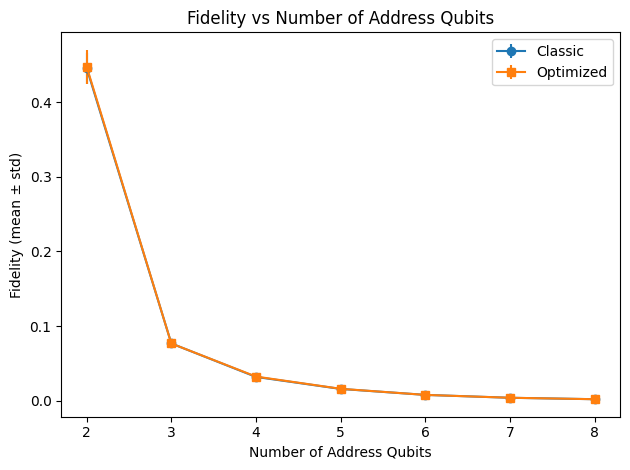

In [9]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Cartella contenente i CSV
csv_dir = Path("data/state_fidelity_noise")

# Regex per estrarre il run_id dal nome del file
pattern = re.compile(r"ffqram_fidelity_run_id_(\d+)\.csv")

# Carica solo i file con run_id da 1 a 10 inclusi
df_list = []
for file in csv_dir.glob("ffqram_fidelity_run_id_*.csv"):
    match = pattern.search(file.name)
    if match:
        run_id = int(match.group(1))
        if 1 <= run_id <= 10:
            df_list.append(pd.read_csv(file))


# Unisci tutti i file in un unico DataFrame
df = pd.concat(df_list, ignore_index=True)
df.head()

grouped = df.groupby("N_address_qubits").agg({
    "fidelity_standard": ["mean", "std"],
    "fidelity_optimized": ["mean", "std"],
    "transpiled_classic_size": "mean",
    "transpiled_gray_size": "mean",
    "transpiled_classic_depth": "mean",
    "transpiled_gray_depth": "mean"
}).reset_index()

# Appiattisci i nomi delle colonne
grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns.values]
grouped


df["fidelity_delta"] = df["fidelity_optimized"] - df["fidelity_standard"]
df.head()


plt.figure()
plt.errorbar(grouped["N_address_qubits"],
             grouped["fidelity_standard_mean"],
             yerr=grouped["fidelity_standard_std"],
             label="Classic", marker='o')
plt.errorbar(grouped["N_address_qubits"],
             grouped["fidelity_optimized_mean"],
             yerr=grouped["fidelity_optimized_std"],
             label="Optimized", marker='s')
plt.title("Fidelity vs Number of Address Qubits")
plt.xlabel("Number of Address Qubits")
plt.ylabel("Fidelity (mean ± std)")
plt.legend()
plt.tight_layout()
plt.savefig("fidelity_mean_std.png")
plt.show()


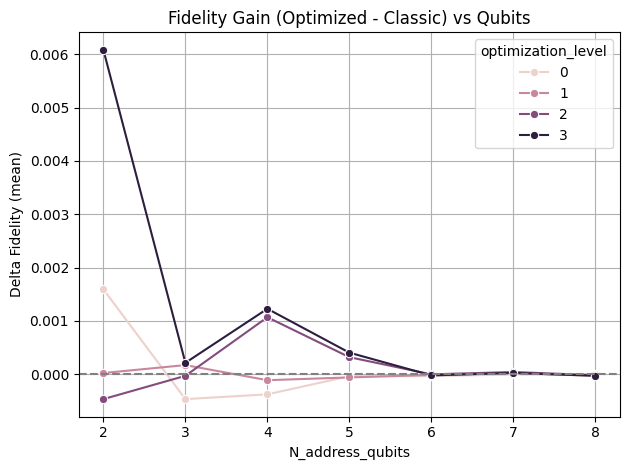

In [29]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Cartella contenente i CSV
csv_dir = Path("data/state_fidelity_noise")

# Regex per estrarre il run_id dal nome del file
pattern = re.compile(r"ffqram_fidelity_run_id_(\d+)\.csv")

# Carica solo i file con run_id da 1 a 10 inclusi
df_list = []
for file in csv_dir.glob("ffqram_fidelity_run_id_*.csv"):
    match = pattern.search(file.name)
    if match:
        run_id = int(match.group(1))
        if 1 <= run_id <= 10:
            df_list.append(pd.read_csv(file))


# Unisci tutti i file in un unico DataFrame
df = pd.concat(df_list, ignore_index=True)
df.head()

# Group by both optimization level and number of qubits
grouped = df.groupby(["optimization_level", "N_address_qubits"]).agg({
    "fidelity_standard": ["mean", "std"],
    "fidelity_optimized": ["mean", "std"],
    "transpiled_classic_size": ["mean", "std"],
    "transpiled_gray_size": ["mean", "std"],
    "transpiled_classic_depth": ["mean", "std"],
    "transpiled_gray_depth": ["mean", "std"]
}).reset_index()

# Appiattisci i nomi delle colonne
grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns.values]

# Ordina per optimization_level prima, poi per N_address_qubits
grouped = grouped.sort_values(by=["optimization_level", "N_address_qubits"]).reset_index(drop=True)

# Visualizza
grouped

import seaborn as sns

# Calcola delta e aggiungilo
grouped["delta_fidelity_mean"] = grouped["fidelity_optimized_mean"] - grouped["fidelity_standard_mean"]

plt.figure()
sns.lineplot(data=grouped, x="N_address_qubits", y="delta_fidelity_mean", hue="optimization_level", marker="o")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Fidelity Gain (Optimized - Classic) vs Qubits")
plt.ylabel("Delta Fidelity (mean)")
plt.grid(True)
plt.tight_layout()
plt.show()


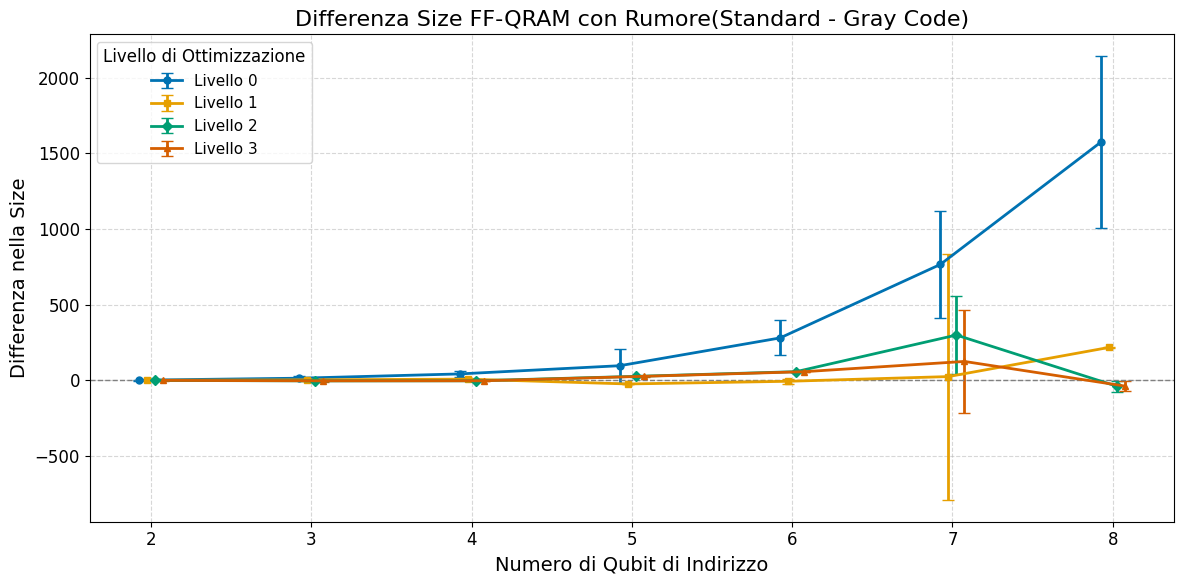

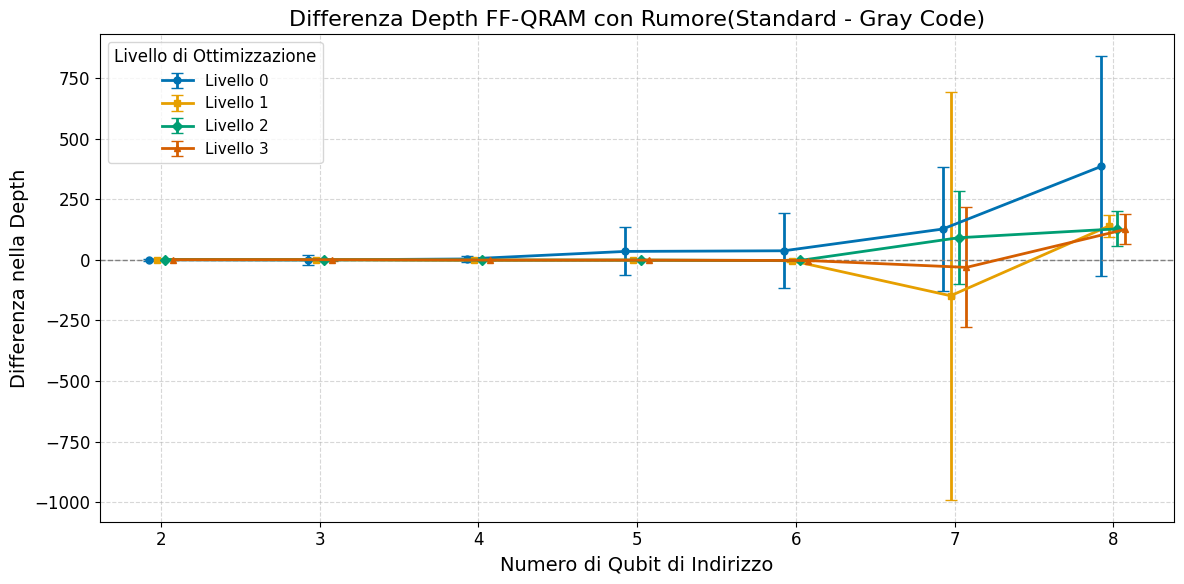

In [34]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === CONFIGURAZIONE ===
csv_dir = Path("data/state_fidelity_noise")
pattern = re.compile(r"ffqram_fidelity_run_id_(\d+)\.csv")

# === CARICAMENTO FILE ===
df_list = []
for file in csv_dir.glob("ffqram_fidelity_run_id_*.csv"):
    match = pattern.search(file.name)
    if match:
        run_id = int(match.group(1))
        if 1 <= run_id <= 35:
            df_list.append(pd.read_csv(file))

df = pd.concat(df_list, ignore_index=True)

# === GROUPBY E STATISTICHE ===
grouped = df.groupby(["optimization_level", "N_address_qubits"]).agg({
    "fidelity_standard": ["mean", "std"],
    "fidelity_optimized": ["mean", "std"],
    "transpiled_classic_size": ["mean", "std"],
    "transpiled_gray_size": ["mean", "std"],
    "transpiled_classic_depth": ["mean", "std"],
    "transpiled_gray_depth": ["mean", "std"]
}).reset_index()

# Appiattisci i nomi delle colonne
grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns.values]

# Ordina
grouped = grouped.sort_values(by=["optimization_level", "N_address_qubits"]).reset_index(drop=True)

# === CALCOLO DIFFERENZE E ERRORI ===
grouped["size_diff"] = grouped["transpiled_classic_size_mean"] - grouped["transpiled_gray_size_mean"]
grouped["size_diff_std"] = np.sqrt(grouped["transpiled_classic_size_std"]**2 + grouped["transpiled_gray_size_std"]**2)

grouped["depth_diff"] = grouped["transpiled_classic_depth_mean"] - grouped["transpiled_gray_depth_mean"]
grouped["depth_diff_std"] = np.sqrt(grouped["transpiled_classic_depth_std"]**2 + grouped["transpiled_gray_depth_std"]**2)

import matplotlib.pyplot as plt
import numpy as np

# === STILE GRAFICO ===
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 12
})

colors = {
    0: "#0072B2",  # blu
    1: "#E69F00",  # arancione
    2: "#009E73",  # verde
    3: "#D55E00"   # rosso scuro
}

linestyles = {0: '-', 1: '--', 2: '-.', 3: ':'}
markers = {0: 'o', 1: 's', 2: 'D', 3: '^'}

# === GRAFICO SIZE ===
plt.figure(figsize=(12, 6))
for opt in sorted(grouped["optimization_level"].unique()):
    subset = grouped[grouped["optimization_level"] == opt]
    x_vals = subset["N_address_qubits"] + (opt - 1.5) * 0.05  # offset X
    y_vals = subset["size_diff"]
    y_errs = subset["size_diff_std"]

    plt.errorbar(x_vals, y_vals, yerr=y_errs,
                 fmt=markers[opt], linestyle='-',
                 linewidth=2, markersize=5, capsize=4,
                 color=colors[opt], label=f"Livello {opt}")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Differenza Size FF-QRAM con Rumore(Standard - Gray Code)", fontsize=16)
plt.xlabel("Numero di Qubit di Indirizzo", fontsize=14)
plt.ylabel("Differenza nella Size", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Livello di Ottimizzazione", loc="upper left", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

# === GRAFICO DEPTH ===
plt.figure(figsize=(12, 6))
for opt in sorted(grouped["optimization_level"].unique()):
    subset = grouped[grouped["optimization_level"] == opt]
    x_vals = subset["N_address_qubits"] + (opt - 1.5) * 0.05
    y_vals = subset["depth_diff"]
    y_errs = subset["depth_diff_std"]

    plt.errorbar(x_vals, y_vals, yerr=y_errs,
                 fmt=markers[opt], linestyle='-',
                 linewidth=2, markersize=5, capsize=4,
                 color=colors[opt], label=f"Livello {opt}")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Differenza Depth FF-QRAM con Rumore(Standard - Gray Code)", fontsize=16)
plt.xlabel("Numero di Qubit di Indirizzo", fontsize=14)
plt.ylabel("Differenza nella Depth", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Livello di Ottimizzazione", loc="upper left", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()



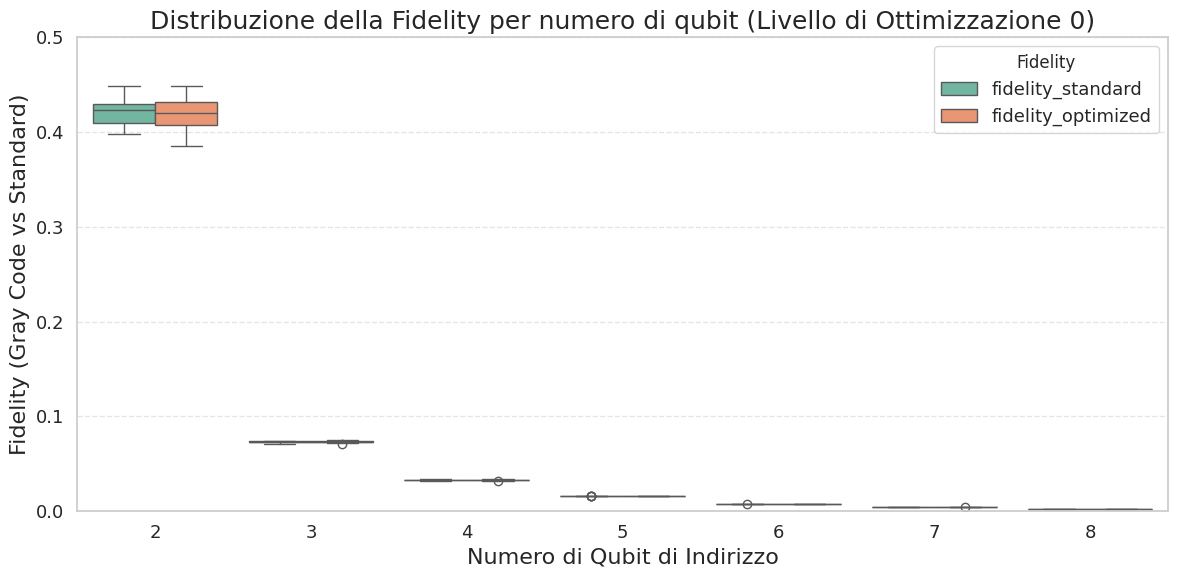

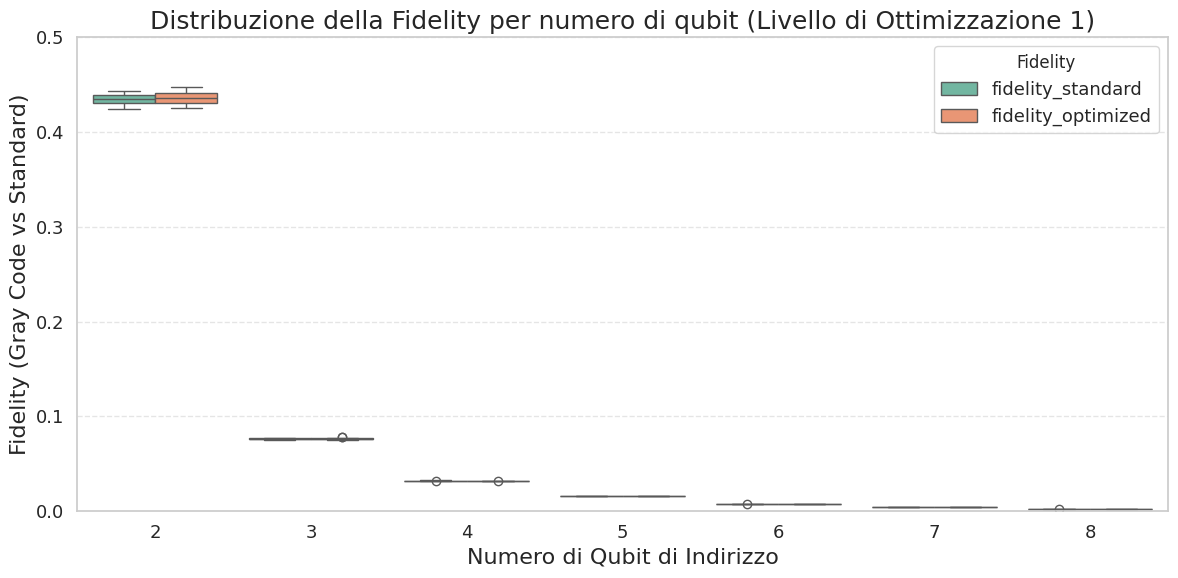

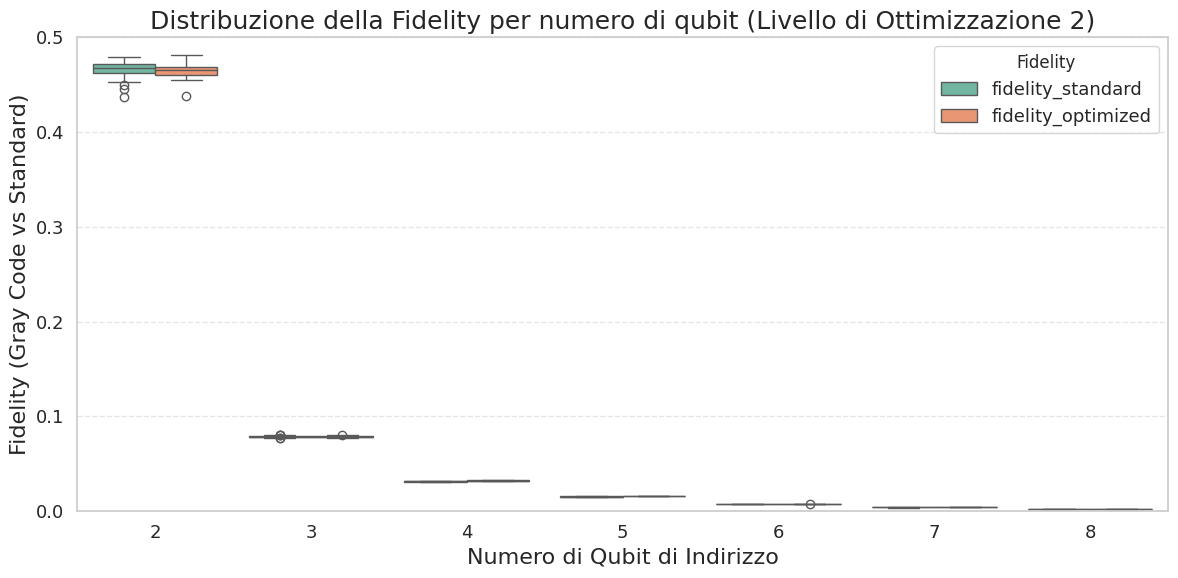

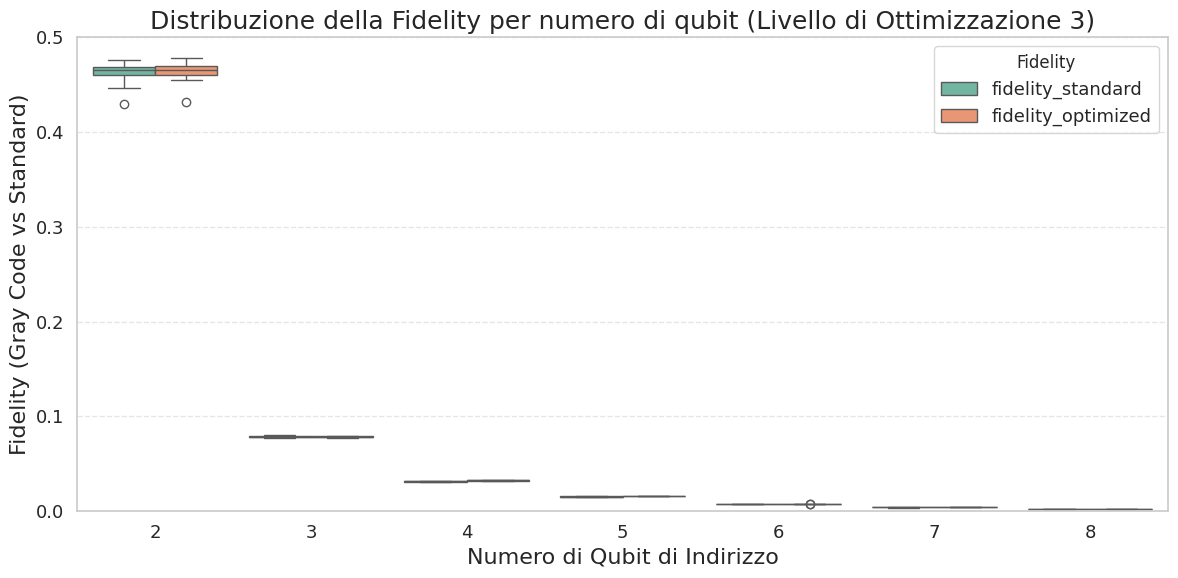

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# === Caricamento dei dati ===
csv_dir = Path("data/state_fidelity_noise")
pattern = re.compile(r"ffqram_fidelity_run_id_(\d+)\.csv")

df_list = []
for file in csv_dir.glob("ffqram_fidelity_run_id_*.csv"):
    match = pattern.search(file.name)
    if match:
        run_id = int(match.group(1))
        if 1 <= run_id <= 35:
            df_list.append(pd.read_csv(file))

df = pd.concat(df_list, ignore_index=True)

# === Preparazione dati in formato long ===
df_long = df.melt(
    id_vars=["N_address_qubits", "optimization_level"],
    value_vars=["fidelity_standard", "fidelity_optimized"],
    var_name="Tipo di Fidelity",
    value_name="Fidelity"
)

# === Stile grafico ===
sns.set(style="whitegrid", font="DejaVu Sans")
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "legend.fontsize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13
})

# === Grafici per ciascun livello di ottimizzazione ===
for level in sorted(df["optimization_level"].unique()):
    subset = df_long[
        (df_long["optimization_level"] == level) &
        (df_long["N_address_qubits"] <= 8) &
        (df_long["N_address_qubits"] > 0)
    ]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
    data=subset,
    x="N_address_qubits",
    y="Fidelity",
    hue="Tipo di Fidelity",
    palette="Set2"
    )


    ax.axhline(1.0, color="gray", linestyle="--", linewidth=1)

    plt.title(f"Distribuzione della Fidelity per numero di qubit (Livello di Ottimizzazione {level})")
    plt.xlabel("Numero di Qubit di Indirizzo")
    plt.ylabel("Fidelity (Gray Code vs Standard)")
    plt.ylim(0, 0.5)
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.legend(title="Fidelity", loc="upper right")
    plt.tight_layout()
    plt.show()


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import os

# === Caricamento dati ===
csv_dir = Path("data/state_fidelity_noise")
pattern = re.compile(r"ffqram_fidelity_run_id_(\d+)\.csv")
df_list = []

for file in csv_dir.glob("ffqram_fidelity_run_id_*.csv"):
    match = pattern.search(file.name)
    if match and 1 <= int(match.group(1)) <= 35:
        df_list.append(pd.read_csv(file))

df = pd.concat(df_list, ignore_index=True)

# === Calcolo medie ===
grouped = df.groupby(["optimization_level", "N_address_qubits"]).agg({
    "transpiled_classic_size": "mean",
    "transpiled_gray_size": "mean",
    "transpiled_classic_depth": "mean",
    "transpiled_gray_depth": "mean"
}).reset_index()

# Rinomina colonne in modo leggibile
grouped.columns = [
    "Livello Ottimizzazione",
    "Qubit Indirizzo",
    "Size Classica (approssimata)",
    "Size Ottimizzata (approssimata)",
    "Depth Classica (approssimata)",
    "Depth Ottimizzata (approssimata)"
]

# Arrotonda e formatta
for col in grouped.columns[2:]:
    grouped[col] = grouped[col].round(0).astype(int).map(lambda x: f"{x:,}".replace(",", "."))

grouped["Qubit Indirizzo"] = grouped["Qubit Indirizzo"].astype(int)

# Crea cartella output se non esiste
os.makedirs("graphics_plots/tabelle", exist_ok=True)

# === Genera tabelle per ogni livello ===
for level in sorted(grouped["Livello Ottimizzazione"].unique()):
    df_level = grouped[grouped["Livello Ottimizzazione"] == level].drop(columns="Livello Ottimizzazione")

    fig, ax = plt.subplots(figsize=(11, 0.6 * len(df_level) + 1))
    ax.axis('off')
    ax.axis('tight')

    table = ax.table(
        cellText=df_level.values,
        colLabels=df_level.columns,
        loc='center',
        cellLoc='center',
        colWidths=[0.25]*len(df_level.columns)
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.1, 1.5)

    plt.title(f"Livello di Ottimizzazione {level}", fontsize=16, fontweight="bold", pad=20)
    plt.tight_layout()
    plt.savefig(f"graphics_plots/tabelle/opt_level_{level}_table.png", dpi=300)
    plt.close()

print("✅ Tabelle salvate come immagini nella cartella 'tabelle/' senza colonna di livello.")



✅ Tabelle salvate come immagini nella cartella 'tabelle/' senza colonna di livello.


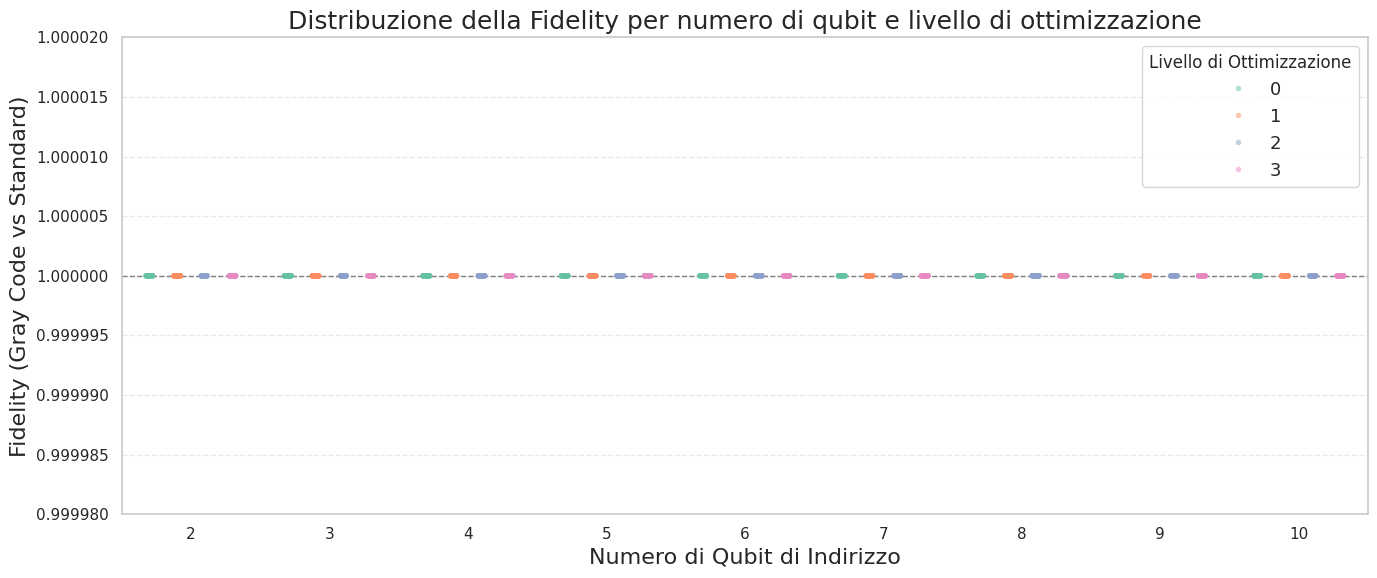

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Caricamento dati
df = pd.read_csv("data/ffqram_fidelity_sv.csv")
df = df.rename(columns={
    "qubit_address": "N_address_qubits",
    "fidelity_gray_vs_classic": "Fidelity"
})

# Stile
sns.set(style="whitegrid", font="DejaVu Sans")
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "legend.fontsize": 13
})

# Figura
fig, ax = plt.subplots(figsize=(14, 6))

# Stripplot
sns.stripplot(
    data=df,
    x="N_address_qubits",
    y="Fidelity",
    hue="optimization_level",
    dodge=True,
    alpha=0.5,
    size=4,
    marker="o",
    palette="Set2",
    ax=ax
)

# Linea di riferimento
ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)

# Imposta i limiti Y attorno a 1
ax.set_ylim(0.99998, 1.00002)

# Disattiva notazione scientifica
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

# Titoli
ax.set_title("Distribuzione della Fidelity per numero di qubit e livello di ottimizzazione")
ax.set_xlabel("Numero di Qubit di Indirizzo")
ax.set_ylabel("Fidelity (Gray Code vs Standard)")

# Legenda chiara
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Livello di Ottimizzazione", loc="best")

# Griglia e layout
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


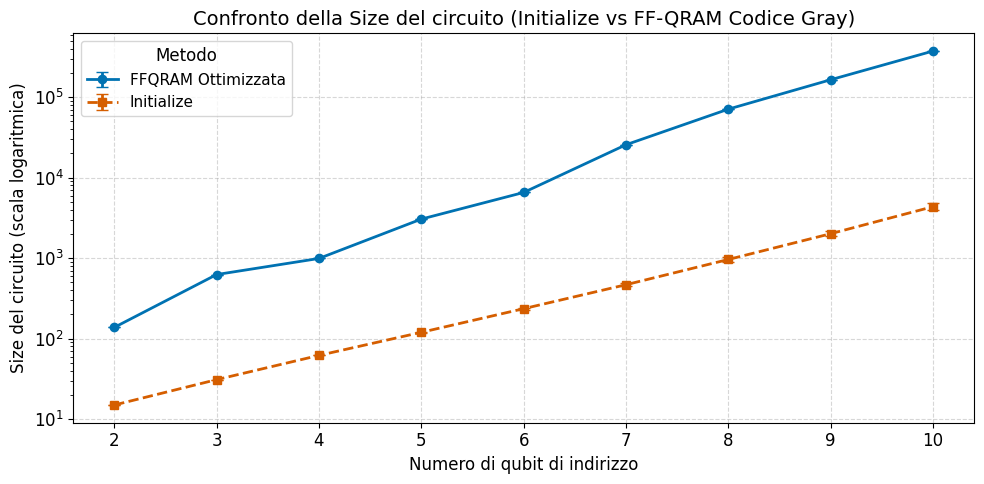

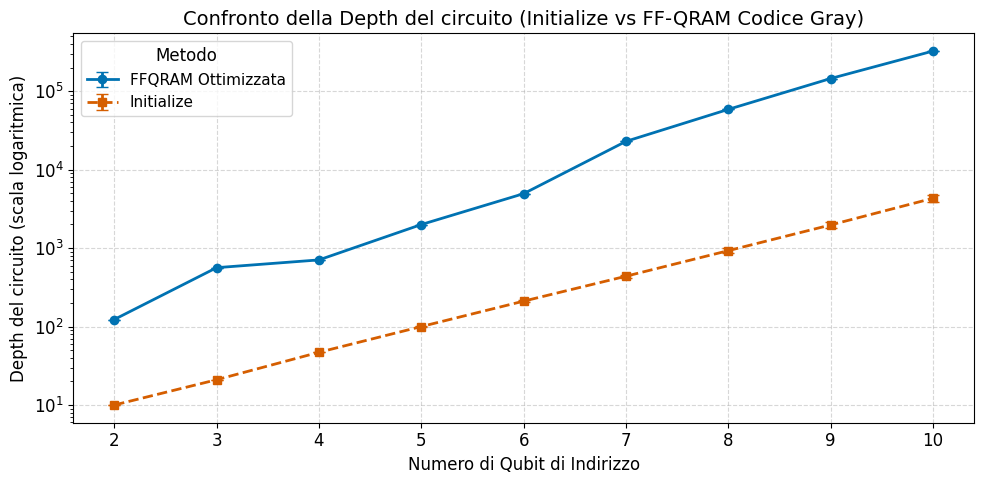

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Caricamento dei dati ===
df = pd.read_csv("data/state_preparation_metrics.csv")

# === Calcolo media e deviazione standard per ogni valore di qubit di indirizzo ===
df_stats = df.groupby("N_address_qubits").agg({
    "optimized_circuit_size": ["mean", "std"],
    "initialize_gate_size": ["mean", "std"],
    "optimized_circuit_depth": ["mean", "std"],
    "initialize_gate_depth": ["mean", "std"]
}).reset_index()

# Rinomina colonne per semplicità
df_stats.columns = ["N_address_qubits",
                    "opt_size_mean", "opt_size_std",
                    "init_size_mean", "init_size_std",
                    "opt_depth_mean", "opt_depth_std",
                    "init_depth_mean", "init_depth_std"]

# === Stile generale ===
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 12
})

# Colori accessibili
colori = {
    "ottimizzata": "#0072B2",   # blu
    "initialize": "#D55E00"     # rosso scuro
}

# === GRAFICO 1: Size del circuito ===
plt.figure(figsize=(10, 5))

x = df_stats["N_address_qubits"]

# FFQRAM Ottimizzata
plt.errorbar(x, df_stats["opt_size_mean"], yerr=df_stats["opt_size_std"],
             label="FFQRAM Ottimizzata", color=colori["ottimizzata"],
             marker='o', linestyle='-', capsize=4, linewidth=2)

# Initialize
plt.errorbar(x, df_stats["init_size_mean"], yerr=df_stats["init_size_std"],
             label="Initialize", color=colori["initialize"],
             marker='s', linestyle='--', capsize=4, linewidth=2)

plt.yscale("log")
plt.title("Confronto della Size del circuito (Initialize vs FF-QRAM Codice Gray)", fontsize=14)
plt.xlabel("Numero di qubit di indirizzo", fontsize=12)
plt.ylabel("Size del circuito (scala logaritmica)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Metodo", fontsize=11)
plt.tight_layout()
plt.show()

# === GRAFICO 2: Profondità del circuito ===
plt.figure(figsize=(10, 5))

# FFQRAM Ottimizzata
plt.errorbar(x, df_stats["opt_depth_mean"], yerr=df_stats["opt_depth_std"],
             label="FFQRAM Ottimizzata", color=colori["ottimizzata"],
             marker='o', linestyle='-', capsize=4, linewidth=2)

# Initialize
plt.errorbar(x, df_stats["init_depth_mean"], yerr=df_stats["init_depth_std"],
             label="Initialize", color=colori["initialize"],
             marker='s', linestyle='--', capsize=4, linewidth=2)

plt.yscale("log")
plt.title("Confronto della Depth del circuito (Initialize vs FF-QRAM Codice Gray)", fontsize=14)
plt.xlabel("Numero di Qubit di Indirizzo", fontsize=12)
plt.ylabel("Depth del circuito (scala logaritmica)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Metodo", fontsize=11)
plt.tight_layout()
plt.show()


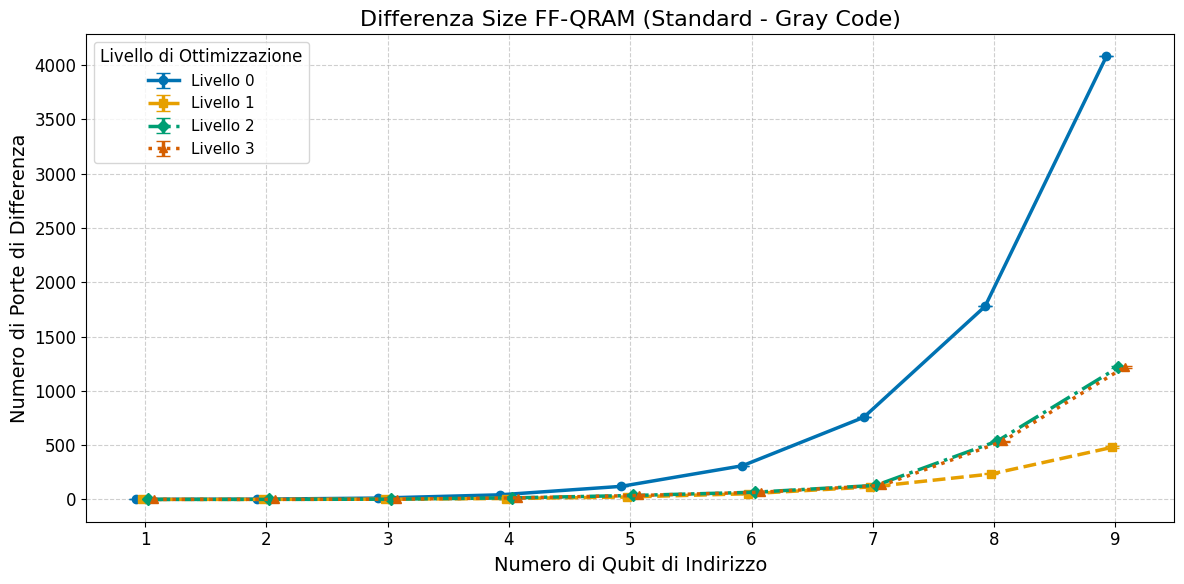

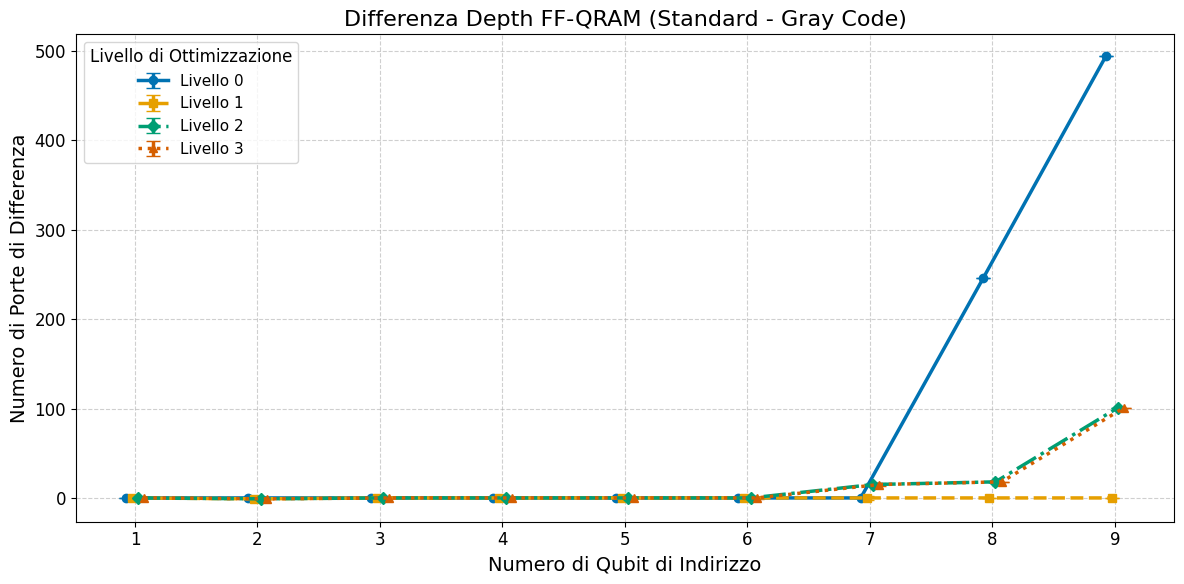

In [30]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# === 1. Caricamento dei dati ===
with open("data/metrics_results.json", "r") as f:
    metrics_data = json.load(f)

# === 2. Inizializzazione struttura ===
raw_data = defaultdict(lambda: defaultdict(lambda: {
    "classic_size": [],
    "gray_size": [],
    "classic_depth": [],
    "gray_depth": []
}))

# === 3. Popolamento delle liste raw ===
for entry in metrics_data:
    opt_level = entry["optimization_level"]
    n_qubits = entry["n"]
    raw_data[opt_level][n_qubits]["classic_size"].append(entry["classic"]["optimized_size"])
    raw_data[opt_level][n_qubits]["gray_size"].append(entry["graycode"]["optimized_size"])
    raw_data[opt_level][n_qubits]["classic_depth"].append(entry["classic"]["optimized_depth"])
    raw_data[opt_level][n_qubits]["gray_depth"].append(entry["graycode"]["optimized_depth"])

# === 4. Calcolo delle medie e deviazioni standard ===
data_by_opt = {}
for opt_level, qubit_dict in raw_data.items():
    data_by_opt[opt_level] = {}
    for n_qubits, metrics in qubit_dict.items():
        data_by_opt[opt_level][n_qubits] = {
            "classic_size_mean": np.mean(metrics["classic_size"]),
            "gray_size_mean": np.mean(metrics["gray_size"]),
            "classic_depth_mean": np.mean(metrics["classic_depth"]),
            "gray_depth_mean": np.mean(metrics["gray_depth"]),
            "classic_size_std": np.std(metrics["classic_size"]),
            "gray_size_std": np.std(metrics["gray_size"]),
            "classic_depth_std": np.std(metrics["classic_depth"]),
            "gray_depth_std": np.std(metrics["gray_depth"])
        }

# === 5. Parametri di visualizzazione ===
opt_levels = sorted(data_by_opt.keys())
address_qubits = sorted({n for d in data_by_opt.values() for n in d})

colors = {
    0: "#0072B2",  # blu
    1: "#E69F00",  # arancione
    2: "#009E73",  # verde
    3: "#D55E00"   # rosso scuro
}

linestyles = {
    0: '-',    # solida
    1: '--',   # tratteggiata
    2: '-.',   # tratto-punto
    3: ':'     # puntinata
}

markers = {
    0: 'o',    # cerchio
    1: 's',    # quadrato
    2: 'D',    # diamante
    3: '^'     # triangolo
}

plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 12
})

# === GRAFICO SIZE ===
plt.figure(figsize=(12, 6))
for opt in opt_levels:
    # offset per separare leggermente le curve (anti-sovrapposizione)
    x_vals = [n + (opt - 1.5) * 0.05 for n in address_qubits]
    y_vals = []
    y_err = []
    for n in address_qubits:
        if n in data_by_opt[opt]:
            classic = data_by_opt[opt][n]["classic_size_mean"]
            gray = data_by_opt[opt][n]["gray_size_mean"]
            classic_std = data_by_opt[opt][n]["classic_size_std"]
            gray_std = data_by_opt[opt][n]["gray_size_std"]

            y_vals.append(classic - gray)
            y_err.append(np.sqrt(classic_std**2 + gray_std**2))

    plt.errorbar(x_vals, y_vals, yerr=y_err,
                 linestyle=linestyles[opt],
                 marker=markers[opt],
                 linewidth=2.5, markersize=6, capsize=5,
                 color=colors[opt], label=f"Livello {opt}")

plt.title("Differenza Size FF-QRAM (Standard - Gray Code)", fontsize=16)
plt.xlabel("Numero di Qubit di Indirizzo", fontsize=14)
plt.ylabel("Numero di Porte di Differenza", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Livello di Ottimizzazione", loc="upper left", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

# === GRAFICO DEPTH ===
plt.figure(figsize=(12, 6))
for opt in opt_levels:
    x_vals = [n + (opt - 1.5) * 0.05 for n in address_qubits]
    y_vals = []
    y_err = []
    for n in address_qubits:
        if n in data_by_opt[opt]:
            classic = data_by_opt[opt][n]["classic_depth_mean"]
            gray = data_by_opt[opt][n]["gray_depth_mean"]
            classic_std = data_by_opt[opt][n]["classic_depth_std"]
            gray_std = data_by_opt[opt][n]["gray_depth_std"]

            y_vals.append(classic - gray)
            y_err.append(np.sqrt(classic_std**2 + gray_std**2))

    plt.errorbar(x_vals, y_vals, yerr=y_err,
                 linestyle=linestyles[opt],
                 marker=markers[opt],
                 linewidth=2.5, markersize=6, capsize=5,
                 color=colors[opt], label=f"Livello {opt}")

plt.title("Differenza Depth FF-QRAM (Standard - Gray Code)", fontsize=16)
plt.xlabel("Numero di Qubit di Indirizzo", fontsize=14)
plt.ylabel("Numero di Porte di Differenza", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Livello di Ottimizzazione", loc="upper left", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

#

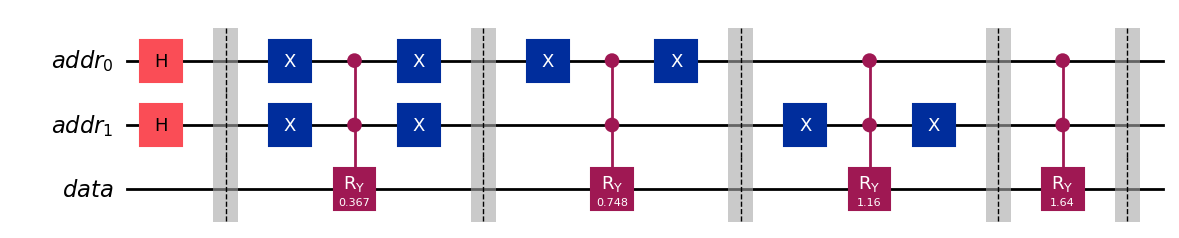

In [15]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import HGate, XGate, RYGate
from numpy import arcsin, sqrt
from matplotlib import pyplot as plt

n=2
N=2**n

memory_values = list(range(1, N+1))

max_value = sum(i**2 for i in memory_values)

qaddr = QuantumRegister(n, name="addr")
qdata = QuantumRegister(1, name="data")
circuit = QuantumCircuit(qaddr, qdata)

for qa in qaddr:
    circuit.append(HGate(), [qa])
circuit.barrier()

for i, el in enumerate(memory_values):
    theta = 2 * arcsin(el / sqrt(max_value))
    binary_index = bin(i)[2:].zfill(n)
    
    for j, bit in enumerate(binary_index):
        if bit == '0':
            circuit.append(XGate(), [qaddr[j]])
    
    CRYGate = RYGate(theta).control(n)
    circuit.append(CRYGate, qaddr[:] + [qdata[0]])
    
    for j, bit in enumerate(binary_index):
        if bit == '0':
            circuit.append(XGate(), [qaddr[j]])
    circuit.barrier()


# Visualizza il circuito
circuit.draw("mpl")

